# <center> Proyecto integrador de la materia Comunicaciones Digitales

In [2]:
#---------------------------------------------------------------------------------
# Project    : Proyecto Integrador
# Authors    : Mugni Juan Mauricio
# Affiliation: UNC
# E-mail     : mauricio.mugni@mi.unc.edu.ar
#---------------------------------------------------------------------------------

## Consigna

Realizar una simulación de la transmisión y recepción con modulación LoRa, en el cual se pueda entender el funcionamiento. 

Luego agregarle ruido y los efectos del canal satelital.

## Resolución

Comenzamos importando las librerías necesarias.

In [8]:
import math
import cmath
import random
import numpy as np
import matplotlib.pyplot as plt
from sympy import li
from scipy.signal import convolve
from scipy.fft import fft, fftfreq, fftshift
from IPython.display import Image

### Marco Teórico

#### ¿Qué es LPWAN?

Es una `red` de área amplia e inalámbrica, especializada para dispositivos con baja tasa de datos, centrándose en el alcance y la eficiencia energética.

Su nombre significa _Low Power Wide Area Network_ (LPWAN).

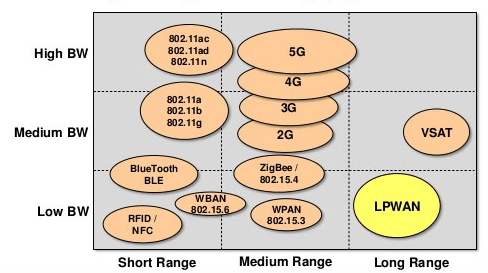

In [14]:
Image(filename='Imagenes/Range-of-different-wireless-technologies-2.png')

Como vemos en la imagen superior, la red que estudiamos, LPWAN, tiene un ancho de banda reducido y puede operar a largas distancias.

A frecuencias bajas, los obstáculos como las paredes y los edificios absorben menos energía de radiofrecuencia, lo que proporciona a estos sistemas una excelente capacidad de penetración en entornos urbanos.

Hay múltiples opciones de `protocolos de comunicación` en la red LPWAN, como LoRaWAN, Sigfox, NB-IoT (_Narrowband Internet of Things_), LTE-M, Weightless, RPMA (Random Phase Multiple Access), Dash7 y MIOTY. Estos están diseñados para conectar sensores que operan a una frecuencia de muestreo baja y envían ráfagas de datos cortos a largas distancias.

Sin embargo, para los desarrollos de IoT (_Internet of Things_) se utilizan principalmente los siguientes:

#### LoraWAN

> LoRaWAN es uno de los más importantes y amplios protocolos para establecer comunicaciones a largas distancias.
>
> Se basa en estándares abiertos administrados por LoRa Alliance y en tecnología de radio de espectro extendido, patentada por _Semtech Corp_. La red utiliza una topología de estrella extendida, lo que permite que los nodos individuales se comuniquen con múltiples puertas de enlace, lo que permite el _roaming_ (término que hace referencia a que el dispositivo se conecta a otra red disponible ya que está fuera de alcance de la red principal).
>
> Este protocolo admite comunicaciones bidireccionales entre puertas de enlace y nodos.

##### Sigfox
> Es un protocolo patentado, desarrollado y administrado por _Sigfox_, que otorga licencias de su tecnología a los desarrolladores de chips y brinda a los usuarios acceso a su red a través de estaciones de base de puertas de enlace a todo el mundo.
>
> Los nodos solo pueden enviar 140 mensajes por día, y las puertas de enlace solo pueden enviar mensajes de enlace a los nodos cuatro veces por día, después de recibir un mensaje de estos.
> 
> Los nodos pasan muy poco tiempo con sus radios activas, permaneciendo en modo suspensión la mayor parte del tiempo para minimizar su consumo de energía.

##### NB-IoT
> NB-IoT es una tecnología LPWAN diseñada específicamente para aplicaciones IoT que requieren transmisión de datos de bajo ancho de banda y bajo consumo de energía.
> 
> Es una de las opciones más nuevas, desarrollada para aplicaciones de medición inteligente y control de procesos.
> Proporciona una cobertura mejorada en áreas interiores y subterráneas, y es compatible con una gran cantidad de dispositivos conectados.
> 
> La comunicación es bidireccional a través de una red en estrella. Cada nodo puede tener una clave de seguridad única, lo que permite que el sistema mantenga el mensaje cifrado desde el nodo hasta el programa de aplicación basado en la nube que interactúa con él. Las puertas de enlace simplemente pueden pasar el mensaje cifrado; no necesitan acceder a su contenido.
>
> NB-IoT se integra en las redes móviles existentes y aprovecha la infraestructura de LTE para ofrecer una solución de conectividad eficiente y escalable.

Basandonos en el siguiente paper: [Overview of Cellular LPWAN Technologies for IoT Deployment: Sigfox, LoRaWAN, and NB-IoT](https://ieeexplore.ieee.org/document/8480255) podemos comparar los principales protocolos utilizados en IoT.

* **Calidad del servicio - QoS (_Quality of Service_)** :
  
    Sigfox y LoRaWAN emplean licencias gratuitas en las bandas sub-GHz y utilizan comunicación asíncrona basada en el protocolo ALOHA. Estas tecnologías pueden experimentar interferencias y [_fading/multi-path_](#seccion-fanding_multipath), por lo que no siempre proporcionan un servicio de alta calidad. Por otro lado, NB-IoT emplea espectro con licencia y se basa en el protocolo síncrono LTE, el cual es óptimo para garantizar la calidad del servicio. Debido a su costo, NB-IoT se utiliza en aplicaciones que requieren asegurar la calidad del servicio, mientras que para aplicaciones que no tienen esta restricción, es preferible elegir Sigfox y LoRaWAN.

   
* **Duración de la batería y latencia (_Battery Life and Latency Performance_ )**:

    La latencia se refiere al tiempo que tarda un paquete de datos en viajar desde su origen hasta su destino. Es una medida de retraso en la transmisión de datos.
  
    Los nodos que utilizan Sigfox, LoRaWAN y NB-IoT están en modo _sleep_ la mayor parte del tiempo. Sin embargo, los dispositivos que utilizan NB-IoT consumen energía adicional debido a la comunicación síncrona y a la calidad del servicio prestada. Esta energía adicional reduce el tiempo de vida de los dispositivos en comparación con aquellos que utilizan Sigfox y LoRaWAN.

  Además, NB-IoT provee una baja latencia en la conectividad, a diferencia de Sigfox y LoRaWAN que también pueden ofrecer baja latencia pero a costa de incrementar el consumo de energía. Por lo tanto, Sigfox y LoRaWAN son la mejor solución para aplicaciones donde la latencia no es relevante, mientras que para aplicaciones IoT que requieren baja latencia, NB-IoT es la mejor opción.

* **Escalabilidad y longitud de carga útil (_Scalability and Payload Length_)**:

  La principal característica de estos protocolos es la capacidad de soportar miles de nodos conectados. Sin embargo, NB-IoT permite conectar más de $100.000$ dispositivos por estación, mientras que Sigfox y LoRaWAN soportan hasta $50.000$ dispositivos.

  La longitud de la carga útil (_payload length_) define la cantidad de datos útiles que se transmiten en un paquete, excluyendo cualquier información adicional utilizada para el manejo y control de paquetes. NB-IoT ofrece la máxima longitud de carga útil. NB-IoT permite transmitir hasta $1600$ bytes, LoRaWAN permite un máximo de $243$ bytes, y Sigfox tiene la menor capacidad con $12$ bytes, lo cual limita su uso en aplicaciones IoT donde se debe enviar una gran cantidad de datos.
  
* **Rango y covertura (_Range and Coverage_)**:

  Una estación de Sigfox puede cubrir hasta $40$ km, mientras que LoRaWAN tiene un rango menor, de hasta $20$ km. NB-IoT, por su parte, cuenta con la menor capacidad de cobertura, con un rango inferior a $10$ km. Por lo tanto, NB-IoT se utiliza principalmente en regiones con cobertura LTE.
  
* **Desarrollo (_Deployment_)**:

  NB-IoT está actualmente en proceso de implementación para establecer su red a nivel mundial. En cambio, LoRaWAN y Sigfox son sistemas maduros que se están comercializando en varios países y ciudades. LoRaWAN tiene la ventaja de estar presente en $42$ países, en comparación con los $31$ países en los que se encuentra Sigfox. A pesar de que LoRaWAN y Sigfox están disponibles en todo el mundo, ambos aún se encuentran en fase de implementación.
  
* **Costo (_Cost Efficiency_)**:

  Al analizar factores como la licencia para transmitir (el costo del espectro), el desarrollo y el precio de los nodos, se concluye que Sigfox y LoRaWAN presentan una ventaja sobre NB-IoT, ya que ofrecen un menor costo en la transmisión, en el desarrollo, así como un menor precio en las puertas de enlace (gateways) y nodos.
  
En la siguiente imagen podemos visualizar lo anteriormente detallado:

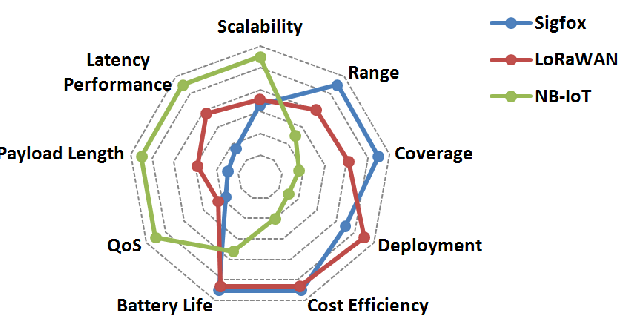

In [19]:
Image(filename='Imagenes/LoraWAN-Sigfox-NBIoT-Grafica.png')

Además se anexa la siguiente tabla para más información.

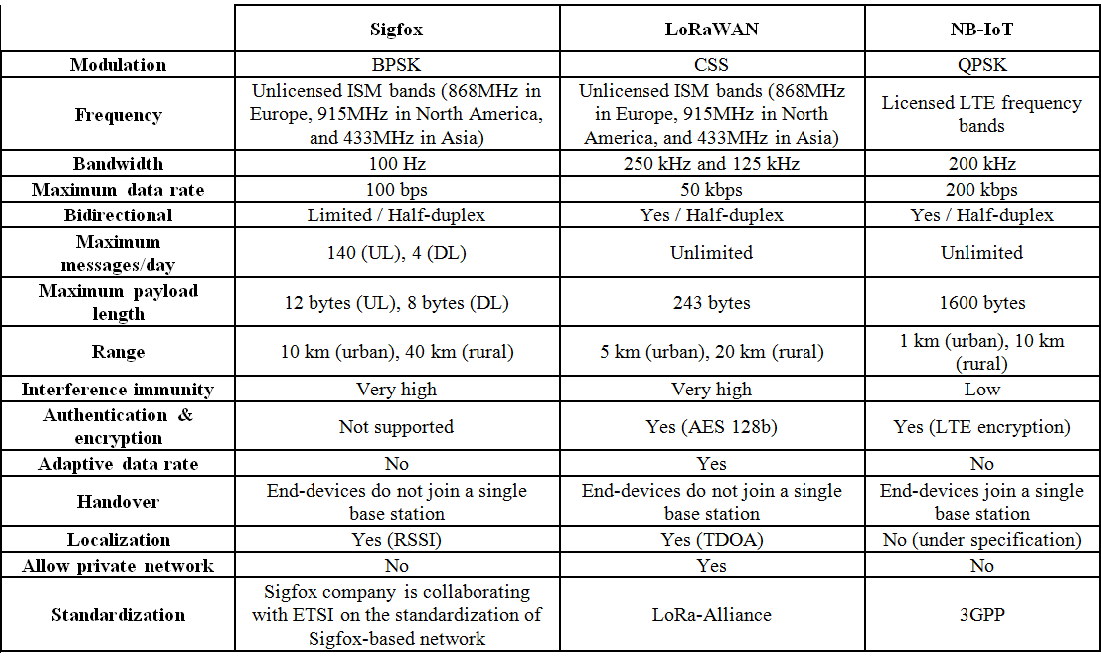

In [22]:
Image(filename='Imagenes/LoraWAN-Sigfox-NBIoT.png')

#### ¿Qué es LoRa?

LoRa es la `capa física` de acceso a la red LoRaWAN, y define el protocolo de acceso a la red y la arquitectura del sistema. Su nombre es la abreviatura de _Long Range_ (largo alcance), y permite:
* Conectividad a larga distancia
* Conexión segura mediante encriptación.
* Envío bidireccional de paquetes de datos.
* Consumo eléctrico mínimo.
* Opera en la banda ISM (_Industrial, Scientific and Medical_) de radio que está habilitada en todo el mundo para uso no comercial y no necesita licencia.
* Las frecuencias utilizadas varían según el país o region.

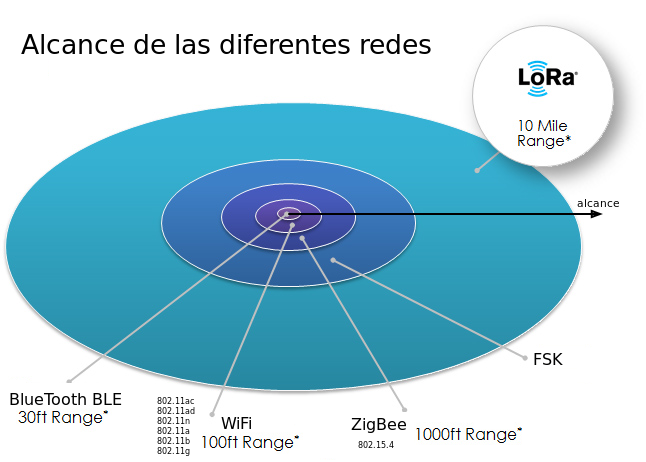

In [26]:
Image(filename='Imagenes/AlcanceLoRaModificado1.png')

Al compararlo con otras modulaciones, teniendo en cuenta el ancho de banda y el alcance, vemos que LoRa tiene un ancho de banda reducido en comparación con el resto. Por esta razón, no se utiliza para enviar vídeos o imágenes. Su uso principal es para el envío de telemetría, es decir, datos de sensores como temperatura, presión, humedad, estado lógico, entre otros.

Sin embargo, LoRa se destaca por la distancia a la que puede llegar, lo que lo convierte en una opción ideal para aplicaciones que requieren un largo alcance.

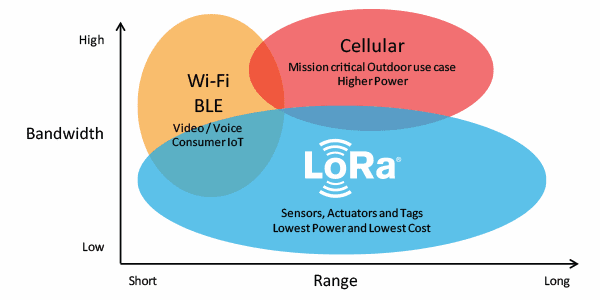

In [29]:
Image(filename='Imagenes/BW&Distancia.png')

No solo puede llegar lejos, sino que también presenta un consumo de energía muy reducido, lo que lo convierte en una opción óptima para aplicaciones IoT (_Internet of Things_).

##### Características de LoRa
Las características claves de la tecnología LoRa son:
- Gran alcance: permite conectar más de $30.000$ aparatos en areas rurales y penetrar densos espacios urbanos.
- Bajo consumo: requiere mínima energía, prolongando la vida útil de las baterías hasta $10$ años. Esto se debe en parte, a que los dispositivos se comunican solo cuando tienen datos listos para ser enviados. No se necesita la sincronización. Cuando un dispositivo transmite, simplemente se despierta, envía un mensaje y se vuelve a dormir.
- Bajo costo: debido a que usa las bandas de frecuencia ISM, se puede operar sin tener que pagar por el espacio aéreo.
- Seguridad: se caracteriza por la encriptación _end-to-end_ AES128, autenticación mutua y protección integrada.
- Estandarización: disponibilidad global en cualquier parte del mundo.
- Geolocalización: permite el desarrollo de aplicaciones de rastreo GPS.
- Portatil: mantiene comunicaciones con dispositivos en movimiento sin sobrecargar el consumo.
- Baja tasa de datos: este protocolo está diseñado para pequeñas cantidades de datos de dispositivos simples como sensores.

##### Aplicaciones de LoRa
Actualmente tiene aplicaciones en:
1. En la agricultura para el monitoreo del ganado, registrando variables como la temperatura, su ubicación y productividad.
2. En los edificios  para predecir fallas, registrar variables como movimiento y temperatura, y controlar motores, luces y otros dispositivos.
3. En las ciudades para hacer más eficiente el uso de la electricidad, controlando la iluminación y encendiendo de manera inteligente ciertas áreas.
4. En la idustria para monitorear recursos como gas, agua, tensión electrica, etc., y poder controlar diversos procesos.
5. En el monitoreo y control satélital. 

#### Modulación

La modulación LoRa se define por los siguientes parámetros:
* **Ancho de banda (BW - _Bandwidth_)**: Es la diferencia entre la frecuencia máxima y mínima.
* **Factor de dispersión (SF - _Spreading Factor_)**: Es la cantidad de bits codificados por símbolo. Puede tomar valores entre $7$ y $12$. La cantidad de símbolos a representar para cada SF es:
  $$2^7 = 128$$
  $$2^8 = 256$$
  $$2^9 = 512$$
  $$2^{10} = 1024$$
  $$2^{11} = 2048$$
  $$2^{12} = 4096$$
* **Tasa de codificación (CR - _Coding Rate_)**: Es una medida de la cantidad de corrección de errores.

La duración de un símbolo, también conocida como duración del _chirp_, se calcula como:
$$ T_S = \frac{2^{SF}}{BW}$$

El numerador, $M = 2^{SF}$, es la cardinalidad del alfabeto de modulación.

Para un SF dado, la transmisión LoRa tiene un conjunto de $M = 2^{SF}$ _chirps_ diferentes, cada uno de los cuales corresponde a uno de los símbolos del alfabeto de modulación: $S={0,1,2,...M-1}$. Para cada secuencia de bits transmitidos, el modulador selecciona la correspondiente modulación del símbolo y transmite el _chirp_, el cual tiene un único símbolo asociado.

En la siguiente imagen se muestra cómo aumenta el tiempo de transmisión (_Time on Air_ - ToA) al aumentar el factor de dispersión.

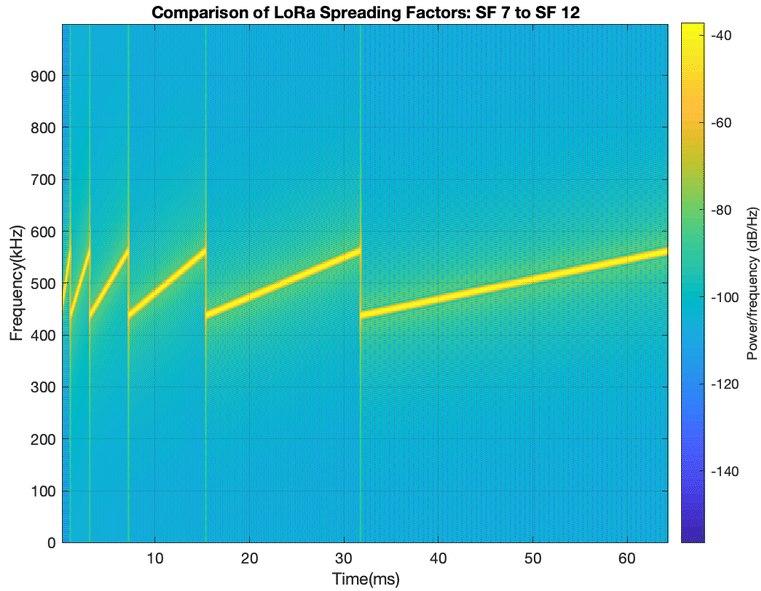

In [34]:
Image(filename='Imagenes/LoRa-uses-a-chirp-spread-spectrum-modulation-technique.png')

La cantidad de datos transmitidos en un período de tiempo específico se conoce como tasa de datos (_bit rate_), y se calcula como:

$$
Bit\space Rate \approx \frac{BW}{2^{SF}} SF
$$

El primer término representa la cantidad de símbolos que se pueden enviar por segundo; al multiplicarlo por la cantidad de bits por símbolo, obtengo la cantidad de bits por segundo (bps).

Se debe tener en cuenta que se coloca el símbolo aproximada en la fórmula, ya que se puede considerar el CR.

Aumentar el SF permite representar más símbolos, lo que podría parecer que permite enviar más información. Sin embargo, debido a que la duración de cada símbolo también aumenta, la tasa de bits efectiva disminuye. Es decir, se pueden transmitir más símbolos diferentes, pero cada símbolo toma más tiempo, resultando en una menor cantidad de bits por segundo.

Un mayor _Spreading Factor_ incrementa el alcance de la señal porque la modulación se vuelve más robusta frente a las interferencias y el ruido. Esto se debe a que la señal se transmite durante un período de tiempo más largo, lo que facilita su detección en el receptor. Sin embargo, se transmiten menos bits por segundo.

El aumento del _Coding Rate_ también influye en la tasa de datos, ya que proporciona mayor corrección de errores mediante la transmisión de bits redundantes. Un mayor CR mejora la robustez frente a errores, pero reduce la velocidad de transmisión de datos.

Mientras que aumentar el ancho de banda incrementa la tasa de datos, ya que permite la transmisión de _chirps_ más cortos.

##### Modulación _Chirp Spread Spectrum_ (CSS)

Para alcanzar un rango amplio, LoRa adopta la modulación *Chirp Spread Spectrum* (CSS), que se utiliza en aplicaciones espaciales y militares.

_Chirp Spread Spectrum_ (CSS) es una técnica de modulación que utiliza _chirps_ (señales cuya frecuencia aumenta o disminuye con el tiempo) para codificar información. Esta técnica es particularmente útil en entornos de comunicaciones inalámbricas debido a su resistencia al ruido, a las interferencias y su capacidad para penetrar obstáculos.

Un _chirp_ es una señal cuya frecuencia cambia linealmente con el tiempo. Existen dos tipos básicos de chirps: 
* chirps ascendentes (_up-chirps_), matemáticamente se puede escribir como:
    $$f(t)=f_0 + kt$$
* chirps descendentes (_down-chirps_):
    $$f(t)=f_0 - kt$$
  
donde $f_0$ es la frecuencia inicial y $k$ es la tasa de cambio de frecuencia.

La señal recibida realiza un barrido en frecuencia, desde una frecuencia incial hasta un límite. Es decir, cuando se alcanza la frecuencia máxima (o mínima para el _down chirp_) se vuelve a la frecuencia mínima (o máxima para el _down chirp_) y el proceso comienza nuevamente. 

En la imagen siguiente, la primera gráfica nos muestra cómo varía la frecuencia de la señal recibida. Puede ser ascendente (la señal azul se mueve de izquierda a derecha) o descendente (la señal azul se mueve de derecha a izquierda). La línea roja indica cuál es la frecuencia sintonizada, y el área sombreada representa el ancho de banda que estamos analizando.

En la segunda gráfica, observamos en rojo cómo la frecuencia se incrementa hasta alcanzar el valor máximo y luego vuelve a empezar para los distintos bits a transmitir. Estamos visualizando la trama de la señal recibida. Además, los colores indican la intensidad de la señal, donde un colo rojo representa mayor potencia que un azul oscuro.

El rojo señala las frecuencias que están por encima del nivel de ruido, mientras que el azul oscuro indica las regiones donde no se ha detectado dicha frecuencia.

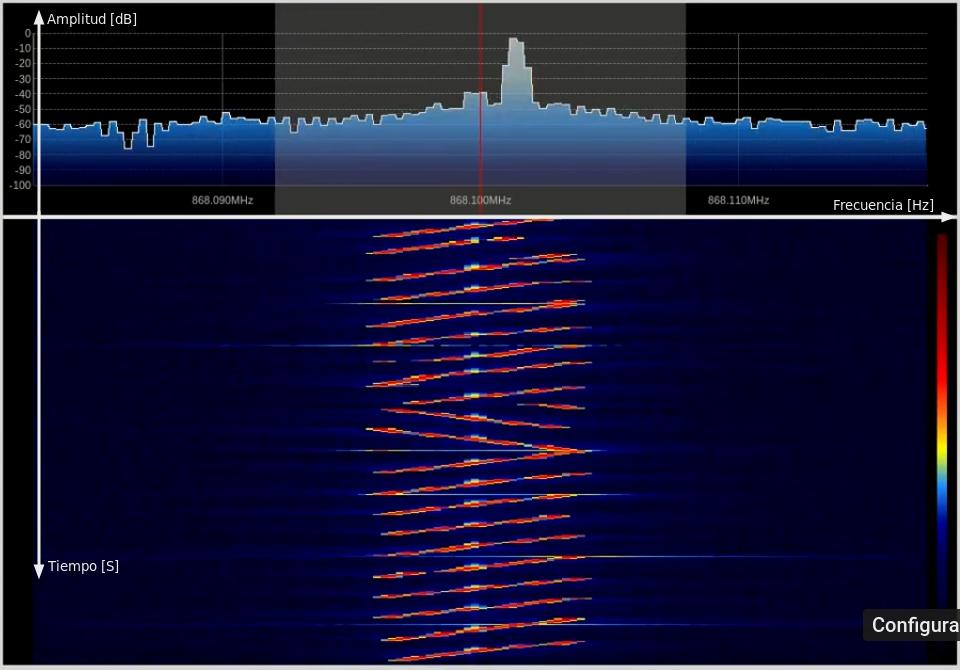

In [39]:
Image(filename='Imagenes/LoRa-Modulation.jpeg')

En en el siguiente [vídeo](https://www.youtube.com/watch?v=MhUbP64o4fg&t=26s) podemos ver una animación que proporciona mayor aclaración sobre el funcionamiento de la modulación CSS y cómo varía la frecuencia de la señal recibida.

En la próxima ilustración se muestra cómo el _chirp_ cambia una señal cosenoidal en el tiempo, para los dos casos mencionados.

En el par de la izquierda, la señal en el tiempo comienza con una frecuencia baja y luego va aumentando, ya que se trata de un _up-chirp_.

En cambio, en el par de la derecha, la señal empieza con una frecuencia alta que luego disminuye, representando un _down-chirp_.

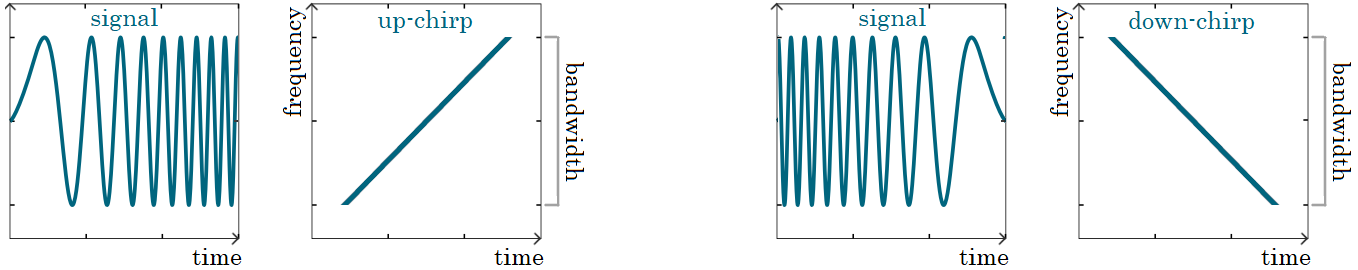

In [42]:
Image(filename='Imagenes/lora-chirps.png')

Se aclara que el ancho de banda no tiene nada que ver con la amplitud de la señal en el tiempo. El ancho de banda está definido por la frecuencia mínima y máxima de la señal, mientras que la amplitud está determinada por la potencia de la misma.

A esta señal de barrido también se la conoce como "chirrido", y puede cambiar su frecuencia a una velocidad constante (como se muestra anteriormente) o exponencial.

##### _Frequency Shift Chirp Modulation_ (FSCM)

Según el artículo [Frequency Shift Chirp Modulation: the $LoRa^{TM}$ Modulation](https://ieeexplore.ieee.org/document/8067462), un análisis minucioso revela que el elemento portador de información es el cambio de frecuencia al comienzo del símbolo y el chirrido es similar a una especie de portadora (_carrier_). Por esta razón, en su opinión, LoRa se describe mejor como una Modulación de Chirrido por Desplazamiento en Frecuencia (_Frequency Shift Chirp Modulation_ - FSCM). 

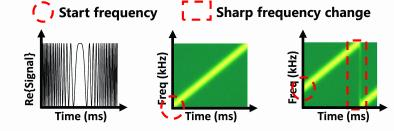

In [47]:
Image(filename='Imagenes/Chirp-Spread-Spectrum.jpg')

Como se muestra en la imagen anterior, un símbolo es un _up-chirp_ o _down-chirp_; en este caso, el primero. La frecuencia de inicio de un símbolo representa la información codificada. Un símbolo LoRa tiene dos segmentos con una caída brusca, como se muestra en el tercer gráfico.

Si se envía un símbolo $s$ cada $T_S$, y el símbolo es un número entero $s(nT_S)$, formado por un vector de bits $w(nT_S)$ con $SF$ dígitos binarios, se puede expresar matemáticamente de la siguiente manera:

$$ s(nT_S) = \sum_{h=0}^{SF-1} w(nT_S)_h \space 2^h $$

Donde los símbolos pueden tomar valores entre $0$ y $2^{SF}-1$.

Por ejemplo, si $SF = 7$ y $w(nT_S)=[1, 0, 1, 1, 0, 1, 0]$, podemos calcular el valor del símbolo de la siguiente manera:

$$
s(nT_S) = 1 \cdot 2^0 + 0 \cdot 2^1 + 1 \cdot 2^2 + 1 \cdot 2^3 + 0 \cdot 2^4 + 1 \cdot 2^5 + 0 \cdot 2^6
$$

$$
=  1 \cdot 1 + 0 \cdot 2 + 1 \cdot 4 + 1 \cdot 8 + 0 \cdot 16 + 1 \cdot 32 + 0 \cdot 64
$$

$$
= 1 + 0 + 4 + 8 + 0 + 32 + 0 = 45
$$

Esto significaque el símbolo enviado en este caso es $45$.

La forma de onda (_waveform_) de duración $T_S$ para un símbolo $s(nT_S)$ es:

$$
\begin{aligned}
\huge c(nT_S + kT) &= \huge \frac{1}{\sqrt{2^{SF}}}e^{j2\pi\left[(s(nT_S)+k)_{\bmod\ 2^{SF}} \right]kT\frac{BW}{2^{SF}}} \\
&= \huge \frac{1}{\sqrt{2^{SF}}}e^{j2\pi\left[(s(nT_S)+k)_{\bmod\ 2^{SF}} \right]\frac{k}{2^{SF}}}
\end{aligned}
$$

donde $k=0, 1, 2, ..., 2^{SF}-1$

Podemos expandir la expresión para mayor claridad:

$$
\begin{aligned}
= \huge \frac{1}{\sqrt{2^{SF}}}\left[cos\left(2\pi\left[(s(nT_S)+k)_{\bmod\ 2^{SF}} \right]\frac{k}{2^{SF}} \right) + j sen\left(2\pi\left[(s(nT_S)+k)_{\bmod\ 2^{SF}} \right]\frac{k}{2^{SF}} \right) \right]
\end{aligned}
$$

Como podemos observar, se están representando las partes real e imaginaria de la señal en el tiempo. Estas actúan como una onda portadora que se modula de acuerdo con el símbolo que estamos transmitiendo.

El argumento de cada función trigonométrica determina la frecuencia de la onda portadora, donde $s(nT_S)$ representa el símbolo actual y $k$ es un ídice que varía para cada paso de tiempo $T$ dentro de la duración del símbolo. La frecuencia de muestreo de un símbolo es:

$$
F_S = \frac{1}{T}
$$

La operación $\bmod\ 2^{SF}$ asegura que el resultado se mantenga dentro del rango posible de $0$ a $2^{SF}-1$.

En la siguiente imagen se indica la modulación de los símbolos $s(nT_S) = 0$ , $s(nT_S) = 33$ y $s(nT_S) = 97$. Se visualiza la duración de cada símbolo y el tiempo entre los distintos valores que toma $k$.

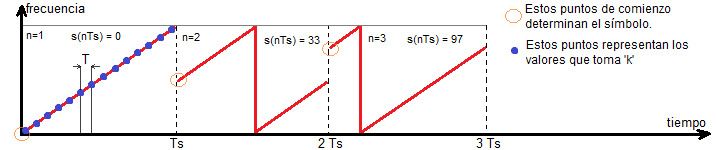

In [52]:
Image(filename='Imagenes/FSCM.jpeg')

Podemos resumir diciendo que la señal se comporta como una forma de onda conocida como _chirp_, donde la frecuencia aumenta o disminuye linealmente con el tiempo.
Cada _waveform_ tiene una frecuencia inicial diferente, determinada por el símbolo que representa.

Esto es conocido como FSCM.

##### Ortogonalidad de las _waveforms_ FSCM

Una vez establecidas las _waveforms_ en la modulación FSCM, se analiza su ortogonalidad.

La ortogonalidad es fundamental para garantizar la transmisión eficiente y confiable de múltiples señales a través del mismo medio, ya que mejora la capacidad del canal y reduce la interferencia. En este análisis, nos enfocamos en la ortogonalidad de las _waveforms_ asociadas a diferentes símbolos.

Para verificar la ortogonalidad, se realiza el producto interno o producto punto de dos _waveforms_ correspondientes a distintos símbolos:

$$
\left\langle \mathbf{c(nT_S + kT)\big|_{s(nT_S)=i}}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = 0 \quad \text{para} \quad i \neq q, \quad i, q \in \{0, \ldots, 2^{SF}-1\}
$$

El producto interno discreto de dos señales discretas se define como:

$$
\left\langle \mathbf{c(nT_S + kT)\big|_{s(nT_S)=i}}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = \sum_{k=0}^{2^{SF}-1} c(nT_S + kT)\big|_{s(nT_S)=i} \space c^*(nT_S + kT)\big|_{s(nT_S)=q}
$$

Donde $2^{SF}-1$ representa la longitud de la señal, y $c^*$ denota el complejo conjugado.

AL reemplazar cada forma de onda por su valor correspondiente, obtenemos:

$$
\left\langle \mathbf{c(nT_S + kT)\big|_{s(nT_S)=i}}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = \frac{1}{2^{SF}}\sum_{k=0}^{2^{SF}-1} e^{j2\pi\left[(i+k) \bmod\ 2^{SF} \right]\frac{k}{2^{SF}}} \cdot e^{-j2\pi\left[(q+k) \bmod\ 2^{SF} \right]\frac{k}{2^{SF}}}
$$

Sacando factor común en el exponente ($\space j2\pi$ y $\frac{k}{2^{SF}}\space$) y agrupando, se tiene:

$$
\large \left\langle \mathbf{c(nT_S + kT)\big|_{s(nT_S)=i}}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = \frac{1}{2^{SF}} \sum_{k=0}^{2^{SF}-1} e^{j2\pi\left[(i+k) \bmod\ 2^{SF} - (q+k) \bmod\ 2^{SF}\right]\frac{k}{2^{SF}}}
$$

Consideramos tres rangos diferentes para $k$:
* **$\space 0 \leq k \leq 2^{SF}-1-i \space$**: En este intervalo, el módulo no afecta el exponente:

$$
\large \sum_{k=0}^{2^{SF}-1-i} e^{j2\pi\left[(i+k)-(q+k)\right]\frac{k}{2^{SF}}} = \sum_{k=0}^{2^{SF}-1-i} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}}
$$

* **$\space 2^{SF}-i \leq k \leq 2^{SF}-1-q\space$**: Aquí, el operador módulo afecta el primer término:

$$
\large \sum_{k=2^{SF}-i}^{2^{SF}-1-q} e^{j2\pi\left[(i+k-2^{SF})-(q+k)\right]\frac{k}{2^{SF}}} = \sum_{k=2^{SF}-i}^{2^{SF}-1-q} e^{j2\pi\left[i-q-2^{SF}\right]\frac{k}{2^{SF}}}
$$

> Simplificando el exponente $2^{SF}$:

$$
\large \sum_{k=2^{SF}-i}^{2^{SF}-1-q} e^{j2\pi\left[i-q-2^{SF}\right]\frac{k}{2^{SF}}} = \sum_{k=2^{SF}-i}^{2^{SF}-1-q} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}}e^{-j2\pi\left[2^{SF}\right]\frac{k}{2^{SF}}}
$$

> Dado que $e^{-j2\pi\space k}$ es $1$ para cualquier entero $k$, podemos simplificar:

$$
\large \sum_{k=2^{SF}-i}^{2^{SF}-1-q} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}}e^{-j2\pi\left[2^{SF}\right]\frac{k}{2^{SF}}} = \sum_{k=2^{SF}-i}^{2^{SF}-1-q} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}}
$$

* **$\space 2^{SF}-q \leq k \leq 2^{SF}-1\space$**:  Aquí, el operador módulo afecta ambos términos:

$$
\large \sum_{k=2^{SF}-q}^{2^{SF}-1} e^{j2\pi\left[(i+k-2^{SF})-(q+k-2^{SF})\right]\frac{k}{2^{SF}}} = \sum_{k=2^{SF}-q}^{2^{SF}-1} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}}
$$

Combinando las tres partes, obtenemos el producto interno total:

$$
\large = \frac{1}{2^{SF}} \sum_{k=0}^{2^{SF}-1-i} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}} + \frac{1}{2^{SF}} \sum_{k=2^{SF}-i}^{2^{SF}-1-q} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}}+ \frac{1}{2^{SF}} \sum_{k=2^{SF}-q}^{2^{SF}-1} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}}}
$$

Cada una de estas sumas involucran el mismo término, y la longitud de los rangos de $k$ cubren todo el intervalo desde $0$ hasta $2^{SF}-1$. Por lo tanto, obtenemos:

$$
\left\langle \mathbf{c(nT_S + kT)\big|_{s(nT_S)=i}}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = \frac{1}{2^{SF}} \sum_{k=0}^{2^{SF}-1} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}} }
$$

Debemos demostrar que esta suma es cero. Para ello, consideramos la fórmula de la suma de una serie geométrica finita:

$$
\sum_{k=0}^{N-1} r^k = \frac{1-r^N}{1-r}
$$

donde $r=e^{j2\pi\left[i-q\right]\frac{1}{2^{SF}} }$ y $N=2^{SF}$. Entonces, tenemos:

$$
\sum_{k=0}^{2^{SF}-1} e^{j2\pi\left[i-q\right]\frac{k}{2^{SF}} } = \frac{1-\left(e^{j2\pi\left[i-q\right]\frac{1}{2^{SF}} } \right)^{2^{SF}}}{1-e^{j2\pi\left[i-q\right]\frac{1}{2^{SF}} }}
$$

Notemos que:

$$
\large \left(e^{j2\pi\left[i-q\right]\frac{1}{2^{SF}} }\right)^{2^{SF}} = e^{j2\pi\left[i-q\right]} = cos\left(2\pi\left[i-q\right]\right) + j\space sin\left(2\pi\left[i-q\right]\right) = 1
$$

Por lo tanto, la expresión se simplifica a:
$$
\frac{1 - 1}{1-e^{j2\pi\left[i-q\right]\frac{1}{2^{SF}} }} = 0
$$

Se concluye que $c(nT_S + kT)\big|_{s(nT_S)=i}$ forma una base ortogonal, ya que se cumple:

$$
\left\langle \mathbf{c(nT_S + kT)\big|_{s(nT_S)=i}}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = 0 \quad \text{para} \quad i \neq q, \quad i, q \in \{0, \ldots, 2^{SF}-1\}
$$

La demostración matemática de la ortogonalidad de las _waveforms_ en la modulación FSCM en sistemas de comunicación LoRa, asegura que diferentes símbolos pueden ser transmitidos simultáneamente sin interferencia entre sí.

#### Demodulación

La señal recibida se expresa como:

$$
r(nT_S + kT) \triangleq c(nT_S + kT) + w(nT_S + kT)
$$

donde $w(nT_S + kT)$ es ruido gaussiano blanco con media cero y varianza $\sigma^2_{w(nT_S+kT)}\triangleq \sigma^2_w$ el cual es independiente de $(nT_S + kT)$.

La detección se realiza proyectando $r(nT_S + kT)$ sobre las diferentes señales $c(nT_S + kT)|_{s(nT_S)=q}$ para $q=0,...,2^{SF}-1$ y elegiendo la señal $c(nT_S + kT)|_{s(nT_S)=l}$ tal que el módulo de la proyección sea máximo.

La proyección se calcula como:
$$
\left\langle \mathbf{r(nT_S + kT)}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = \sum_{k=0}^{2^{SF}-1} r(nT_S+kT) \space c^*(nT_S + kT)|_{s(nT_S)=q}
$$

Se reemplaza $\space c^*(nT_S + kT)|_{s(nT_S)=q} \space$ por su expresión conjugada:

$$
\space c^*(nT_S + kT)|_{s(nT_S)=q} \space =\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi\left[(q+k) \bmod\ 2^{SF} \right]\frac{k}{2^{SF}}}
$$

La proyección se convierte en:

$$
\left\langle \mathbf{r(nT_S + kT)}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = \sum_{k=0}^{2^{SF}-1} r(nT_S+kT) \space \frac{1}{\sqrt{2^{SF}}}e^{-j2\pi\left[(q+k) \bmod\ 2^{SF} \right]\frac{k}{2^{SF}}}
$$

El resultado obtenido representa la correlación o proyección de la señal recibida $r(nT_S+kT)$ con cada una de las posibles señales $c(nT_S + kT)|_{s(nT_S)=q}$. Esto implica multiplicar cada señal recibida por todas las funciones base posibles y seleccionar aquella que obtenga el valor más alto, que sería la _waveform_ del símbolo que se deseaba transmitir.

La imagen siguiente ilustra, a la derecha, las señales en frecuencia para facilitar la visualización, aunque se debe tener en cuenta que estamos trabajando en el dominio del tiempo. A la izquierda, se presentan los resultados de cada correlación.

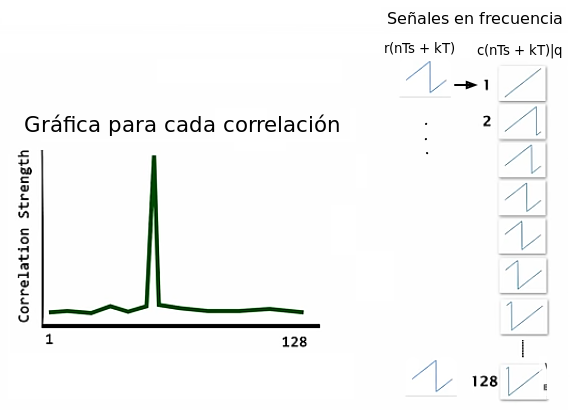

In [63]:
Image(filename='Imagenes/Correlacion.png')

Este método resulta ineficiente, ya que se debe comparar cada símbolo recibido con $2^{SF}$ posibilidades. Para mejorar la eficiencia, se puede simplificar la expresión del exponente:

$$
\large e^{-j2\pi\left[(q+k) \bmod\ 2^{SF} \right]\frac{k}{2^{SF}}} = e^{-j2\pi\frac{qk}{2^{SF}}}\space e^{-j2\pi\frac{k^2}{2^{SF}}}
$$

Esto se cumple para $q+k < 2^{SF}$ .

La expresión final de la proyección es:

$$
\left\langle \mathbf{r(nT_S + kT)}, \mathbf{c(nT_S + kT)\big|_{s(nT_S)=q}} \right\rangle = \frac{1}{\sqrt{2^{SF}}} \sum_{k=0}^{2^{SF}-1} r(nT_S+kT) \space e^{-j2\pi\frac{qk}{2^{SF}}} e^{-j2\pi\frac{k^2}{2^{SF}}}
$$

Donde  $e^{-j2\pi\frac{k^2}{2^{SF}}}$ es la señal base, conocida como _down-chirp_,  y $\space q \space$ representa el índice de cada función base correspondiente a dicho símbolo.

En resumen, el primer paso consiste en multiplicar la señal recibida por un _down-chirp_. Este proceso se conoce como _dechirping_.

$$
       r(nT_S + kT)\space e^{-j2\pi\frac{k^2}{2^{SF}}}
$$

En lugar de comparar con todas las funciones base posibles (correlación), que equivaldría a aplicar la Transformada Discreta de Fourier (_Discrete Fourier Transform_ - DFT) de la señal resultante, se aplica la Tranformada Rápida de Fourier (_Fast Fourier Transform_ - FFT) para identificar la componente con la máxima magnitud, que corresponde al símbolo transmitido. Esto logra mayor eficiencia que realizar el producto punto de cada señal recibida entre las $2^{SF}$ señales posibles.
   $$
       F F T \left\{  r(nT_S + kT)\space e^{-j2\pi\frac{k^2}{2^{SF}}}\right\}
   $$

El símbolo transmitido se identifica al encontrar la frecuencia (índice de la FFT) que tiene la mayor magnitud, la cual corresponde al valor del símbolo $q$. De esta manera, se logra un bajo consumo y menores requerimientos de _hardware_.

#### Formato de la trama en la transmisión LoRa

Los llamados pulsos de "chirrido" se envían como símbolos, los cuales aumentan o disminuyen su frecuencia a lo largo del tiempo.

La transmisión de datos se realiza mediante la secuencia de estos pulsos de "chirrido".

En la siguiente imagen, podemos ver cómo es la secuencia de "chirridos" enviados:

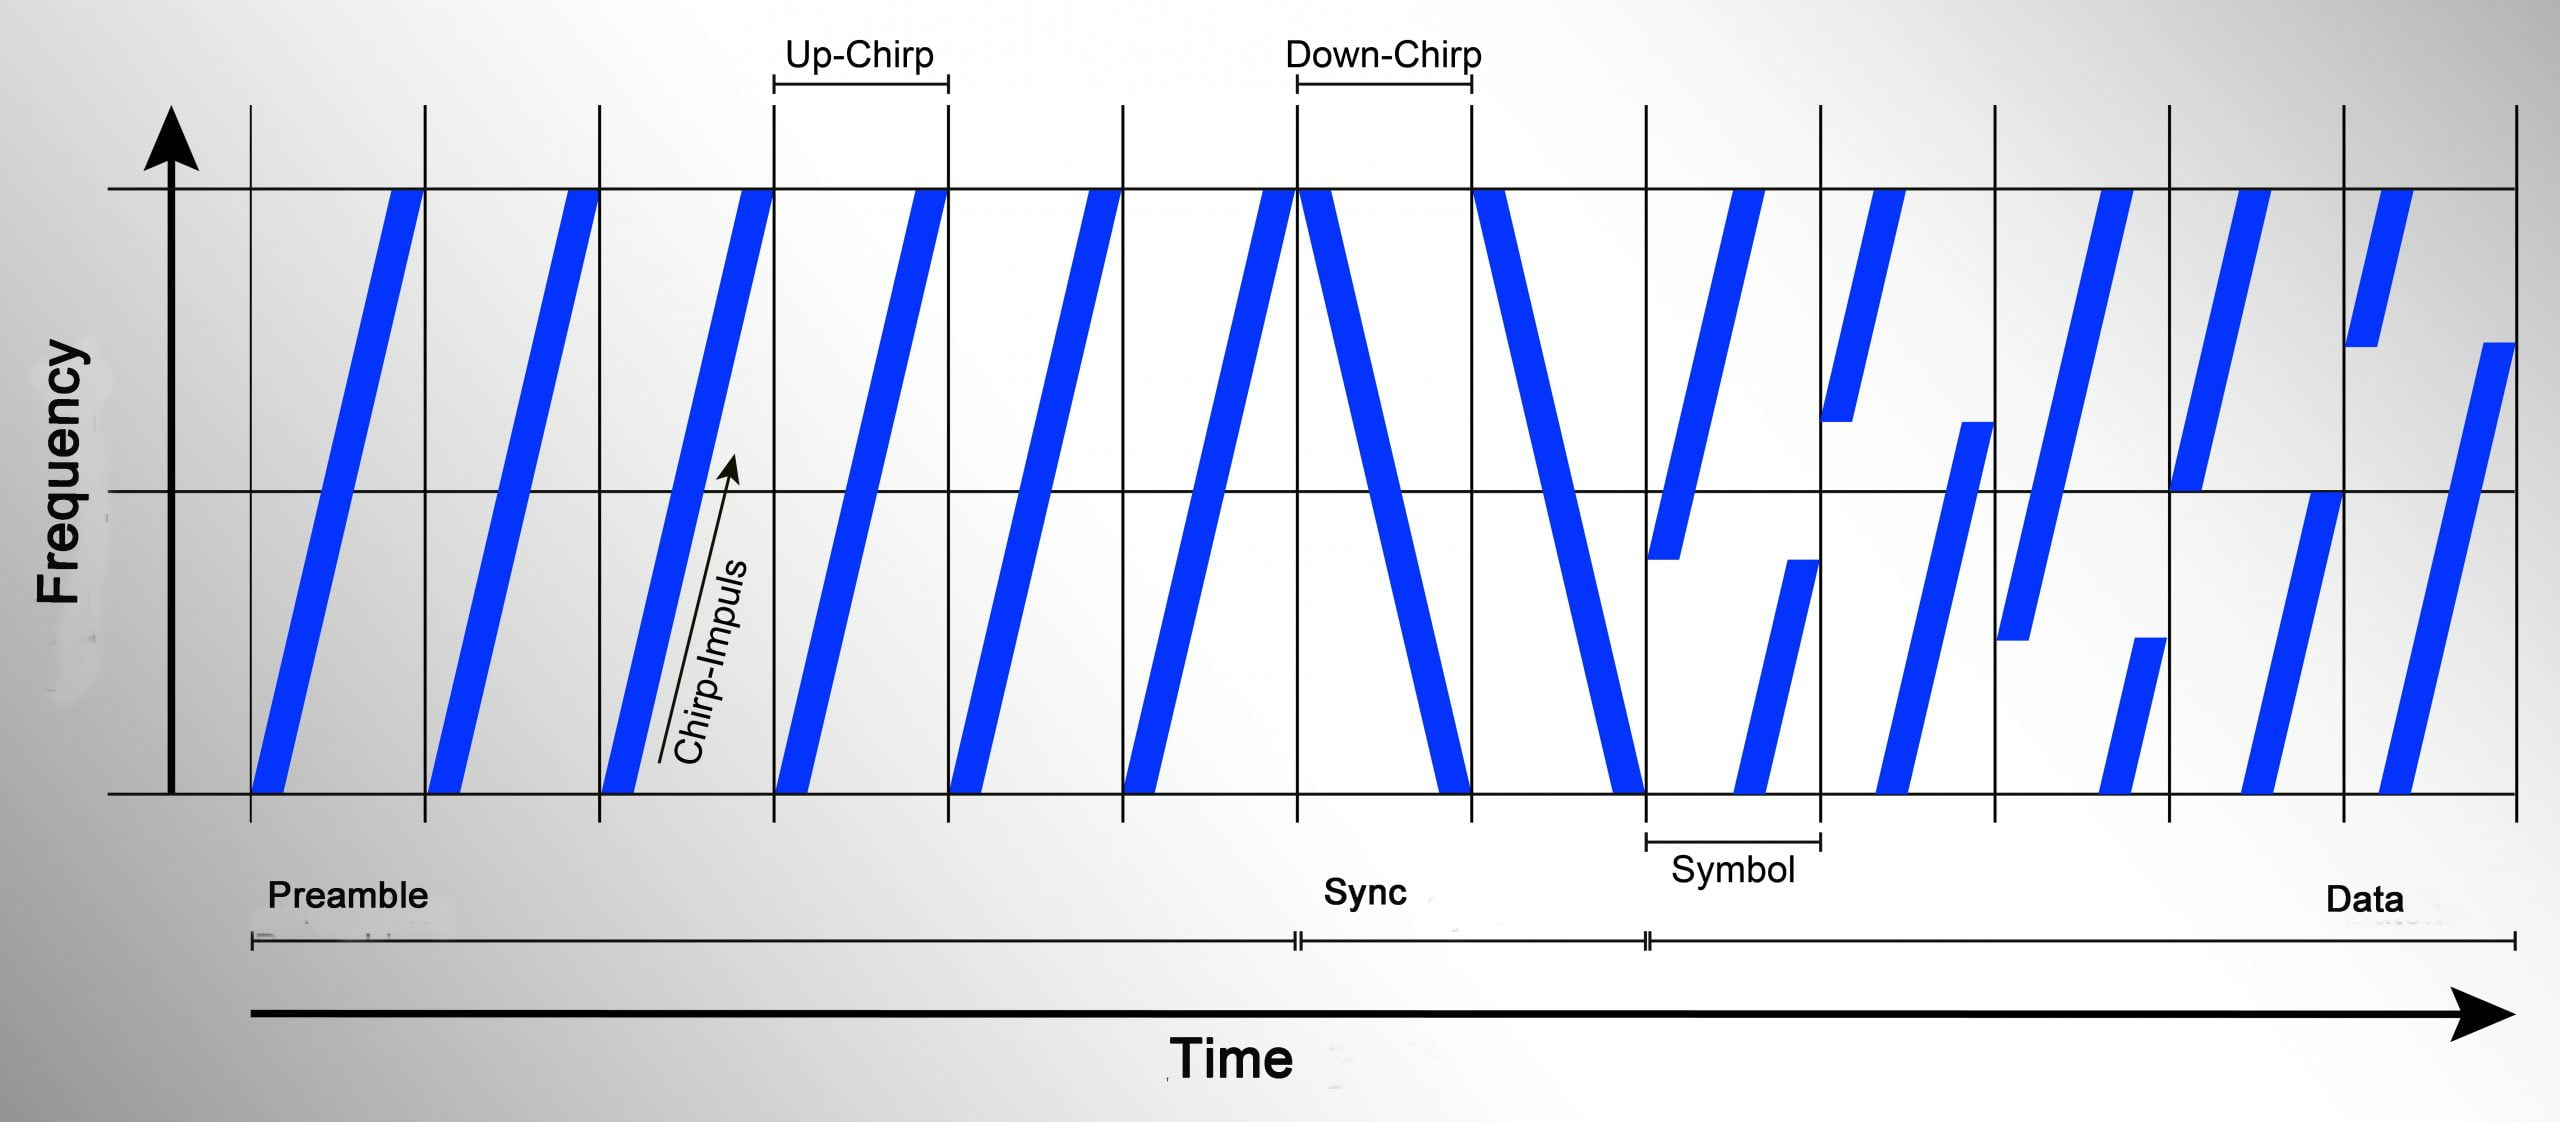

In [70]:
Image(filename='Imagenes/lora-Frequency-scaled.jpg')

Cuando se procesa un mensaje LoRa, se transmite primero el `preámbulo`, que consiste en varios "chirridos" constantes para lograr la detección de la señal LoRa. Hay que tener en cuenta que el receptor puede estar desalineado; por esta razón, se envía el símbolo cero varias veces para poder calibrar el receptor. El preámbulo se compone de dos a diez _up-chirps_, siendo el símbolo cero repetido varias veces. 

Para realizar la calibración mencionada, al detectar cierta cantidad de símbolos repetidos, se calibra el receptor de la siguiente manera:

$$
corrección\space de\space sincronización = \frac{cantidad\space de\space símbolos\space repetidos}{valor\space del\space símbolo}
$$

Esto indica el tiempo que debe ser restado para obtener el símbolo correcto.

Los dos _down-chirps_ siguientes son para la `sincronización` de tiempo. Luego, se comienza con la transmisión de `datos`, que están formados por los `símbolos`.

Después de la información (_payload_) se puede agregar un CRC (_Cyclic Redundancy Check_), pero esto es opcional. En la imagen anterior, este no aparece.

La señal a transmitir por la modulación LoRa tiene el siguiente formato:

<center> $|$ Preamble o Preámbulo $|$ Header o Encabezado $|$ Payload o Información $|$ CRC (opcional) $|$ <center> 

De esta manera queda formada la `trama de la señal`.

En caso de recibir una señal con la estructura del paquete completa, se deben detectar las diferentes partes y eliminar las dos primeras para quedarse con la información.

<a id="seccion-fanding_multipath"></a>
##### _Fading_
El _fading_ se refiere a la variación en la amplitud y la fase de la señal recibida causada por cambios en el entorno de propagación de la señal. Esto puede ser debido a:
* _Fading_ de Desvanecimiento Lento (_Large-scale fading_): Ocurre debido a estructuras grandes que bloquean o reflejan la señal, como edificios o pronunciaciones en el relieve.
* _Fading_ de Desvanecimiento Rápido (_Small-scale fading_): Ocurre debido a cambios pequeños en el entorno, como movimientos de objetos o del receptor, lo que causa fluctuaciones rápidas en la señal.
##### _Multi-path_
El _multi-path_ ocurre cuando la señal transmitida sigue múltiples trayectorias para llegar al receptor. Estas trayectorias pueden incluir reflexiones, refracciones, difracciones y dispersión en objetos como edificios, vehículos, y árboles. Las señales de diferentes trayectorias pueden llegar al receptor en diferentes tiempos, causando interferencias constructivas y destructivas.
* Desvanecimiento por Interferencia Constructiva/Destructiva: Cuando las señales de diferentes caminos se suman constructivamente (en fase), la señal recibida es más fuerte. Cuando se suman destructivamente (fuera de fase), la señal se debilita.
* Retrasos de _Multi-path_ (Multipath Delay Spread): Diferentes trayectorias causan retardos de tiempo variados, lo que puede distorsionar la señal recibida y causar intersímbolo interferencia (ISI) en sistemas de comunicación digital.
* _Doppler Shift_: Si los objetos que causan las múltiples trayectorias están en movimiento, puede haber un cambio en la frecuencia de la señal recibida debido al efecto Doppler, lo que puede afectar la coherencia de la señal.

#### Comunicación con satélites

Esta modulación es un opción potencial para proveer conexión directa a satélites (_direct to satellite_ DtS) apoyando las aplicaciones IoT (_Internet of Things_) y complementando las redes terrestres existentes.

El efecto Doppler es el principal desafío en las comunicaciones LoRa DtS.

Recientes estudios confirman la factibilidad de integrar LoRa con satélites LEO (_Low Earth Orbit_). Sin embargo, solo algunos estudios examinan la influencia del efecto Doppler en el rendimiento de la comunicación LoRa DtS.

Para evitar caer de nuevo a la Tierra debido a la atracción de la gravedad, los satélites LEO orbitan a una velocidad mucho más rápida que la velocidad de rotación de la Tierra. Como  consecuencia del movimiento relativo del satélite y el dispositivo terrestre de recepción, la frecuencia de la portadora de la señal transmitida sufre un cambio significante conocido como `Efecto Doppler`, cuya magnitud varía durante el intervalo de visibilidad del satélite.

Según el _paper_ [_Understanding the Limits of Lora Direct-to-Satellite: The Doppler Perspectives_](https://ieeexplore.ieee.org/document/10335927/references#references), utilizando un _Spreading Factor_ de 12 la conexión DtS es más vulnerable al fenómeno _Doppler Shift_ que para valores bajos de SF.

Las pruebas experimentales confirman que LoRa es más inmune al efecto Doppler cuando se utiliza $7<SF<11$ y un acho de banda mayor a $31.25 kHz$. 

Se analizan dos efectos Doppler:
* Doppler Shift, también llamado Doppler estático.
> Esté degrada el rendimiento de la comunicación para bajos ángulos de elevación, es decir, para la máxima distancia entre el dispositivo receptor y el satélite.
>
> La frecuencia de la portadora se la señal recibida se devía significativamente de la frecuencia de la portadora de la señal transmitida. Esta discrepancia puede producir fallas en la _Phase Locked Loop_ (PLL) de manera tal que no se puede rastrear la señal de entrada y se producen pérdidas de paquetes.
   
* Doppler Rate, conocido como Doppler dinámico.
> En cambio, esté presenta perdidas de paquetes para altos ángulos de elevación. Es decir, para cuando se posiciona justo debajo del dispositivo de recepción terrestre; resulta ser la mínima distancia entre ambos.
>
> Este suceso afecta la capacidad del receptor a permanecer vínculado a la portadora recibida.

La siguiente imagen muestra las regiones afectadas de la comunicación debido al efecto Doppler Shift (marcadas en gris) y por Doppler Rate (marcadas en rojo).




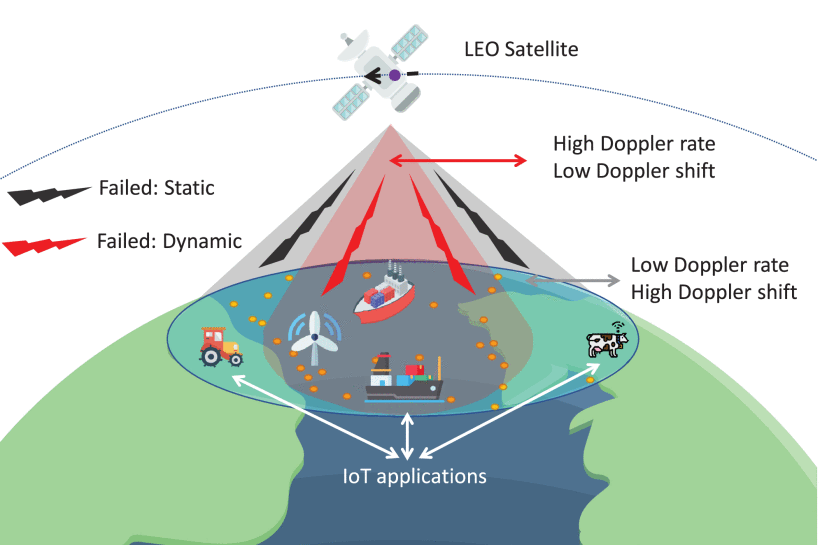

In [76]:
Image(filename='Imagenes/SatelliteDoppler.png')

Recordando que en la cardinalidad del alfabeto de modulación hay M _chirps_, los cuales comienzan con diferentes frecuencias. Estas hacen un barrido según el ancho de banda, desde la inicial hasta la final.

Esto significa que para valores grandes de SF, corresponde a bajos valores de BW, siendo más sensibles al efecto Doppler porque es menor la separación entre las frecuencias de los _chirps_.

Para incrementar la robustez del efecto Doppler dinámico se reduce por dos el número de bits portados por cada símbolo. Para un SF dado, la cardinalidad del alfabeto de modulación se reduce a:
$$M= 2^{SF-2}$$
se incrementa de esta manera la separación de frecuencia entre los chirps por cuatro veces, y por lo tanto, se reduce el efecto del Doppler Rate. Este resultado positivo es a costa de reducir la velocidad de datos.

Para investigar la comunicación LoRa DtS, se comienza explicando la geometría entre el satélite y el dispositivo terrestre.

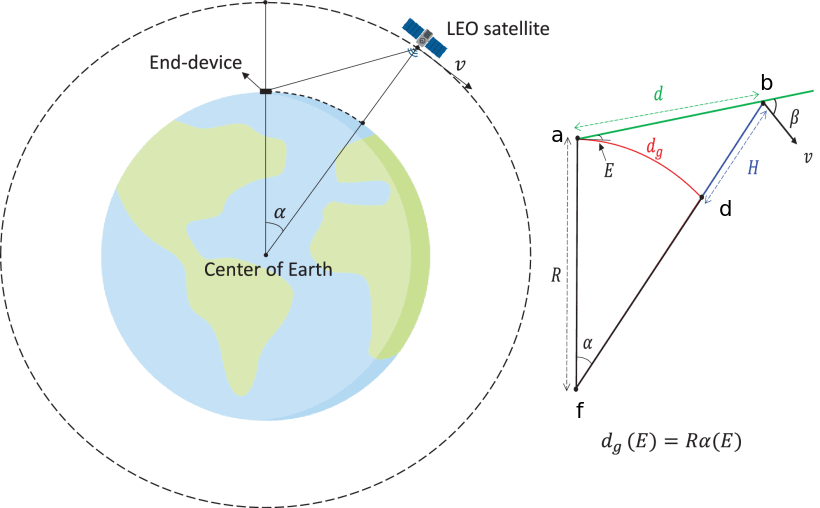

In [79]:
Image(filename='Imagenes/EarthAndSatellite.png')

donde: 

$R = 6371 [km]$ es el radio de la tierra.

$g = 9.81 [\frac{m}{s^2}]$ es la aceleración de la gravedad terrestre.

$c = 299.792.458 [\frac{m}{s}]$ es la velocidad de la luz en el vacío.

$H [km]$ es la altura de la órbita del satélite, distancia del mismo con respecto al suelo.

$d [km]$ es la distancia entre el satélite y el punto de recepción-transmisión.

$v [\frac{km}{h}]$ es la velocidad del satélite en la órbita circular.

$E [°]$ es el ángulo de elevación, está formado por el satélite y el punto terrestre.

$\alpha [rad]$ es el ángulo entre el satélite y el punto _end-device_ teniendo en cuenta el centro de la tierra.

$\beta [°]$ es el ángulo entre la velocidad del satélite y la dirección del punto de operación terrestre.

$\tau $ es el tiempo de visibilidad.

Basandonos en la imagen anterior, uno puede encontrar $d$ para un $E$ dado, y viceversa.

$$ d(E) = R \left[ \sqrt{\left(\frac{H+R}{R}\right)^2 - \cos^2(E) - \sin^2(E)} \right] $$
$$ E(d) = \sin^{-1}\left(\frac{H^2 + 2HR - d^2}{2dR}\right)$$

La proyección del segmento $\overline{ab}$ sobre la superficie terrestre crea un arco definido por el suelo, $d_g(E)$. El largo de este arco es equivalente al producto del radio de la tierra por el ángulo $\alpha$. 

$$d_g(E) = R\alpha(E) = Rsin^{-1}\left(\frac{d(E)cos(E)}{R+H}\right)$$

El tiempo de visibilidad total es definido por:

$$ \tau = 2\frac{d_g(E{min})}{v}$$

Para mantener una orbita circular los satélites LEO giran alrededor de la Tierra a una velocidad muy alta, la cual resulta en un movimiento relativo del satélite respecto a un observador en la superficie terrestre. Este fenómeno introduce un importante cambio de frecuencia en la portadora de la señal recibida, estorbando la demodulación.

La diferencia entre la frecuencia de la portadora de la señal transmitida $F_C$ y la recibida $F_R(t)$, esta última variando en el tiempo debido al movimiento del satélite, se conoce como `Doppler Shift`, y está dado por:

$$F_D(t) = F_R(t) - F_C$$

mientras que su derivada:

$$\Delta F_D(t) = \frac{dF_D(t)}{dt}$$

se conoce como `Doppler Rate`.

Podemos escribir la frecuencia recibida $F_R(t)$ en función de la transmitida $F_C$.

$$F_R(t) = \frac{F_C}{1+\frac{v}{c}cos(\beta(t))}$$

siendo:

$$cos(\beta(t)) = \frac{sin(\varphi(t))}{\sqrt{\left(1+\frac{H}{R}\right)^2 - 2 \left(1 + \frac{H}{R}\right) cos(\varphi(t)) + 1}}$$

en donde:

$$
\large \varphi(t) = t \sqrt{\frac{g}{R}} \left( 1 + \frac{H}{R}\right)^{-\frac{3}{2}}
$$

se debe tener en cuenta que $-\frac{\tau}{2}<t<\frac{\tau}{2}$, y al valer cero el satélite tiene un ángulo de elevación de $E = 90[°]$

Según los experimentos y los documentos de _Semtech Corp_ la modulación LoRa tiene una tolerancia de $\pm25\%$ del ancho de banda al desplazamiento en frecuencia. Por lo tanto, este límite de inmunidad para el Doppler estático es:

$$F_{static} = \pm 0.25 \space BW$$

y la variación de la frecuencia de la portadora sobre el tiempo de la recepción de paquetes debería estar por debajo de:

$$F_{dynamic} = \frac{L \space BW}{3 \space 2^{SF}}$$

donde $L$ vale $16$ cuando el LDRO (_Low Data Rate Optimization_) esta habilitado, y $1$ en caso contrario. Para LoRaWAN, el LDRO es recomendable cuando el símbolo LoRa excede $16.38 [mS]$.

Para modelar el efecto Doppler en el rendimiento de la comunicación LoRa se seguirá el siguiente modelo:

$$
L_{static}(t) =
\begin{cases} 
    1 & \text{if } |F_D(t)|>=|F_{static}| \\
    0 & \text{otherwise } 
\end{cases}
$$
> Refleja las pérdidas de paquetes debido al Doppler estático

$$
L_{dynamic}(t) =
\begin{cases} 
    1 & \text{if } |\Delta F_E(t)|>=F_{dynamic} \\
    0 & \text{otherwise } 
\end{cases}
$$

> Refleja las pérdidas de paquetes debido Doppler dinámico

Donde $\Delta F_E(t)$ representa el cambio en la frecuencia de la portadora desde el comienzo hasta el final de un paquete, definido por:

$$\Delta F_E = F_D[t_{start}] - F_D[t_{end}]$$

$t_{start}$ es el instante en que se comienza con la recepción del paquete, y $t_{end} = t_{start} + ToA$ representa el instante final de la recepción del paquete.

Teniendo en cuenta que ToA (_Time on Air_ - Tiempo en el aire) está dado por  $ToA = T_S \space N_S$, donde $T_S$ como antes vimos es la duración del símbolo y $N_S$ es la cantidad de símbolos en un paquete. 


### Simulación de una transmisión y recepción con modulación LoRa de un solo símbolo

Se comienza simulando el caso para un solo símbolo modulado mediante LoRa.

El parámetro `SNR` se utiliza para comparar el nivel de ruido con respecto a la señal.

* Si es _positivo_, significa que la potencia de la señal es mayor que la potencia del ruido.

* Si es _negativo_, significa que la potencia del ruido es mayor que la potencia de la señal.

El parámetro `ruido` me permite indicar cuál quiero analizar:
* 0: se trabaja con un canal ideal
* 1: _Aditive White Gaussian Noise_ - AWGN
* 2: Canal satelital

Con `veces`, indico la cantidad de iteraciones de detección de símbolos para realizar el histograma. 

In [86]:
s   = 0                  # Símbolo a representar
SF  = 7                  # Spreading Factor [7,8,9,10,11,12]
BW  = 1000               # Ancho de banda
Fs  = 1000               # Frecuencia de muestreo 

SNR = -5                 # Signal Noise Radio
ruido = 1                # Tipo de ruido: 0-> Sin ruido, 1 -> AWGN, 2 -> Canal Satelital
veces = 1000             # cantidad de veces que se modula y demodula para calcular el error

#-----------Efectos del canal satelital------------#
K = 10                   # Factor K para el desvanecimiento de Rician
doppler_freq = 1         # Frecuencia Doppler
#delay_samples = 100      # Retardo en muestras  
atenuacion_factor = 0.5  # Factor de atenuación

#### Transmisor

A continuación, se define la función para modular una onda para cada símbolo $s$ dado.

Los parámetros de entrada serán: `T_s`, `num_samples`(el número de muestras en un símbolo), `s`, y `SF`.

Esta función retorna la modulación en frecuencia y en el tiempo de cada símbolo.

In [90]:
def generar_symb(Ts, num_samples, s, SF):
    
    k = s
    
    symb_f = np.zeros(num_samples, dtype=np.float64)
    symb_t = np.zeros(num_samples, dtype=np.complex128)

    for n in range(num_samples):
        
        if k >= 2**SF:
            k = k - 2**SF
        
        k = k + 1 

        # Símbolo en frecuencia
        symb_f[n] = k

        # Símbolo en tiempo
        symb_t[n] = (1 / np.sqrt(2**SF)) * np.exp(1j * 2 * np.pi * k * (k / (2 * 2**SF)))  # Chirps ascendentes

    return symb_t, symb_f

Se calcula la duración de cada símbolo y el número de muestras, $num\space samples = T_S\space F_S$.

In [93]:
Ts = (2**SF)/BW            # Periodo de cada símbolo
num_samples = int(Ts * Fs) # Número de muestras

print("Duración de casa símbolo: ", Ts, " [S]")

Duración de casa símbolo:  0.128  [S]


Se modula una onda para el símbolo dado.

In [96]:
[symb_t, symb_f] = generar_symb(Ts, num_samples, s, SF)

Se define el vector de tiempo del símbolo y la cantidad de puntos que este tiene.

In [99]:
time_axis = np.arange(num_samples) * 1000 / Fs     #Vector tiempo que será usado en las imagenes siguiente
message_part = 2**SF                               # Cantidad de puntos de cada símbolo

Procedemos a graficar las variaciones de frecuencia y tiempo por símbolo en el eje real. Primero definimos la siguiente función:

In [102]:
# Función para reducir código:
def plot_subplot(data, time_axis, title, xlabel, ylabel, subplot_position, part='real'):
    plt.subplot(5, 1, subplot_position)
    if part == 'real':
        plt.plot(time_axis, data.real)
        plt.title(title + " - Parte Real")
    elif part == 'imag':
        plt.plot(time_axis, data.imag)
        plt.title(title + " - Parte Imaginaria")
    else:
        raise ValueError("El parámetro 'part' debe ser 'real' o 'imag'.")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

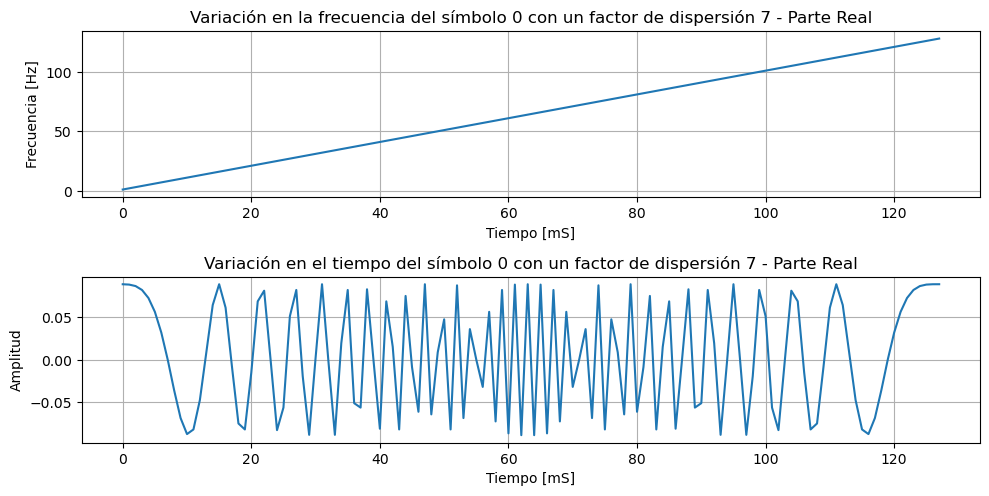

In [104]:
plt.figure(figsize=(10, 12))

# Subplot 1: Variación en la frecuencia por símbolo (parte real)
plot_subplot(symb_f, time_axis, 
            f"Variación en la frecuencia del símbolo {s} con un factor de dispersión {SF}", 
            "Tiempo [mS]", "Frecuencia [Hz]", 1, part='real')

# Subplot 2: Variación en el tiempo por símbolo (parte real)
plot_subplot(symb_t, time_axis, 
             f"Variación en el tiempo del símbolo {s} con un factor de dispersión {SF}", 
             "Tiempo [mS]", "Amplitud", 2, part='real')

plt.tight_layout()
plt.show()

Estas son las gráficas correspondientes a la modulación LoRa de un símbolo.

En el gráfico de la frecuencia, podemos ver que se inicia en la frecuencia del símbolo a transmitir y asciende hasta su máximo $2^{SF}$, provocando una discontinuidad, y luego vuelve a empezar.

En la siguiente representación, notamos cómo cambia la frecuencia de la onda en el tiempo. Se puede observar que en la discontinuidad es donde la señal tiene menor frecuencia. 

#### Ruido

Le agregamos ruido a la señal. Para ello, se crea la siguiente función, que recibe los parámetros: `s`, `SNR`, y `ruido`. 

In [109]:
def agregar_ruido(s, SNR, ruido):

    if ruido == 0: # Sin ruido - canal ideal
        
        return s
    
    else: # Ruido AWGN   
        # Cálculo de potencia de señal y conversión a decibelios
        prom_watts = np.mean(np.abs(s)**2)
        prom_db = 10 * np.log10(prom_watts)

        # Cálculo de ruido en watts
        prom_ruido_db = prom_db - SNR
        noise_avg_watts = 10 ** (prom_ruido_db / 10)

        # Generar ruido blanco complejo
        noise = np.sqrt(noise_avg_watts / 2) * (np.random.normal(0, 1, len(s)) + 1j * np.random.normal(0, 1, len(s)))

        # Añadir ruido a la señal original
        simb_ruidoso = s + noise

        if ruido == 1: # Ruido AWGN 
            
            return simb_ruidoso     
        
        else:         # Efectos canal satélital: AWGN + desvanecimiento Rician + retardo + atenuación  --> sin retardo por el momento

            num_samples = len(simb_ruidoso)
            t = np.arange(num_samples) / Fs

            # Componente LOS
            los_component = np.sqrt(K / (K + 1)) * simb_ruidoso           

            # Componente multipath
            multipath_component = np.zeros_like(simb_ruidoso, dtype=np.complex128)
            num_paths = 10  # Número de caminos en el modelo de desvanecimiento Rician
            
            for i in range(num_paths):
                phase_shift = 2 * np.pi * np.random.rand()
                doppler_shift = doppler_freq * np.cos(2 * np.pi * np.random.rand()) * t
                multipath_component += (1 / np.sqrt(num_paths)) * np.exp(1j * (2 * np.pi * doppler_shift + phase_shift))

            multipath_component = np.sqrt(1 / (K + 1)) * simb_ruidoso * multipath_component
            rician_signal = los_component + multipath_component

            # Aplicar retardo
            #delayed_signal = np.zeros_like(rician_signal, dtype=rician_signal.dtype)
            
            #if delay_samples < len(rician_signal):
            #    delayed_signal[delay_samples:] = rician_signal[:-delay_samples]

            # Aplicar atenuación
            #attenuated_signal = delayed_signal * atenuacion_factor
            attenuated_signal = rician_signal * atenuacion_factor

            return attenuated_signal

Se agrega ruido a la señal, lo que da lugar a la generación de símbolos ruidosos.

In [112]:
 symb_ruidoso = agregar_ruido(symb_t, SNR, ruido)

Graficamos nuevamente el símbolo en el tiempo para apreciar el efecto.

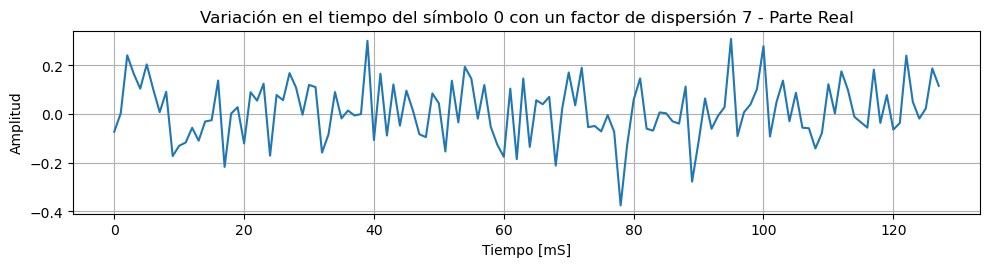

In [115]:
plt.figure(figsize=(10, 12))

# Subplot 1: Variación en el tiempo del símbolo más ruido (parte real)
plot_subplot(symb_ruidoso, time_axis, 
             f"Variación en el tiempo del símbolo {s} con un factor de dispersión {SF}", 
             "Tiempo [mS]", "Amplitud", 1, part='real')

plt.tight_layout()
plt.show()

#### Receptor

Se genera un _chirp_ de referencia descendente `base_down_chirp`. Primero, definimos la función:

In [119]:
def calcular_base_down_chirp(SF, num_samples):
    
    symb_f = np.zeros(num_samples, dtype=np.float64)
    symb_t = np.zeros(num_samples, dtype=np.complex128)
    
    k = 0 # Estos chirps descendentes son siempre 0           
    
    for n in range(num_samples):
        
        if k >= 2**SF:
            k = k - 2**SF
        
        k = k + 1
        
        # Símbolo en frecuencia
        symb_f[n] = 2**SF - k
        
         # Símbolo en el tiempo
        symb_t[n] = (1 / np.sqrt(2**SF)) * np.exp(-1j * 2 * np.pi * k * (k / (2**SF * 2)))  # Chirps descendentes
    
    return symb_t, symb_f

Generamos el _down-chirp_:

In [121]:
[base_down_chirp_t, base_down_chirp_f] = calcular_base_down_chirp(SF, num_samples)

Se grafica para observar cómo sería la señal utilizada para la demodulación.

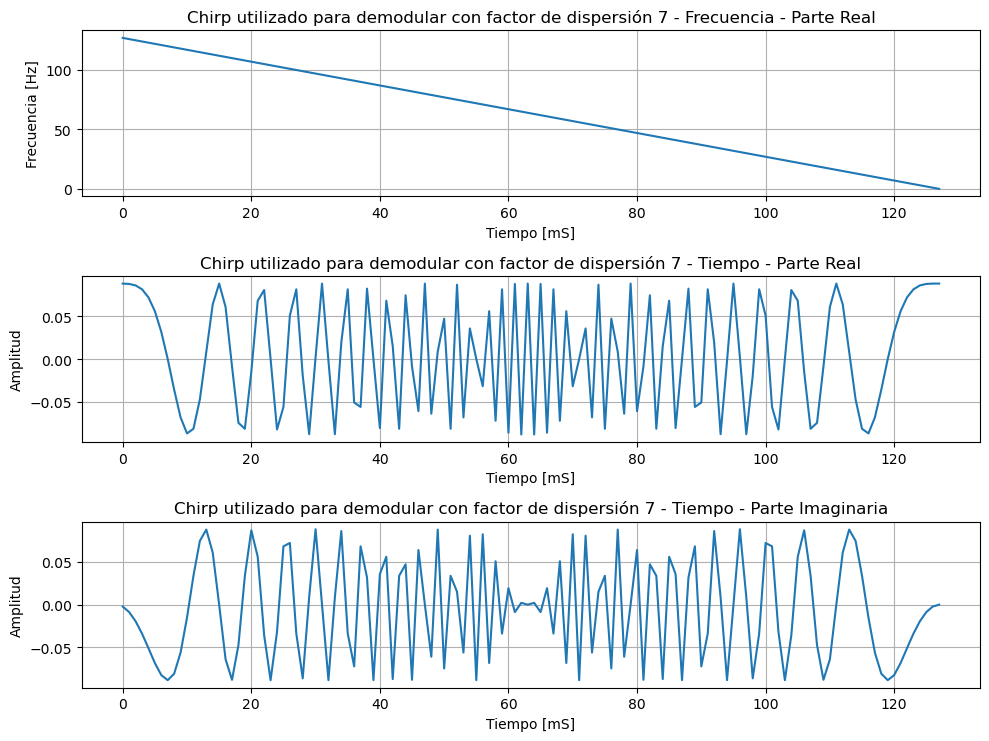

In [124]:
plt.figure(figsize=(10, 12))

# Subplot 1: Variación en la frecuencia del down-chirp (parte real)
plot_subplot(base_down_chirp_f, time_axis, 
             f"Chirp utilizado para demodular con factor de dispersión {SF} - Frecuencia", 
             "Tiempo [mS]", "Frecuencia [Hz]", 1, part='real')

# Subplot 2: Variación en el tiempo del down-chirp (parte real)
plot_subplot(base_down_chirp_t, time_axis, 
             f"Chirp utilizado para demodular con factor de dispersión {SF} - Tiempo", 
             "Tiempo [mS]", "Amplitud", 2, part='real')

# Subplot 3: Variación en el tiempo del down-chirp (parte imaginaria)
plot_subplot(base_down_chirp_t, time_axis, 
             f"Chirp utilizado para demodular con factor de dispersión {SF} - Tiempo", 
             "Tiempo [mS]", "Amplitud", 3, part='imag')

plt.tight_layout()
plt.show()

Cada símbolo de la señal recibida se multiplica por el _chirp_ descendente de referencia.

In [127]:
dechirped =  symb_ruidoso * base_down_chirp_t

Se grafica el símbolo demodulado en el tiempo:

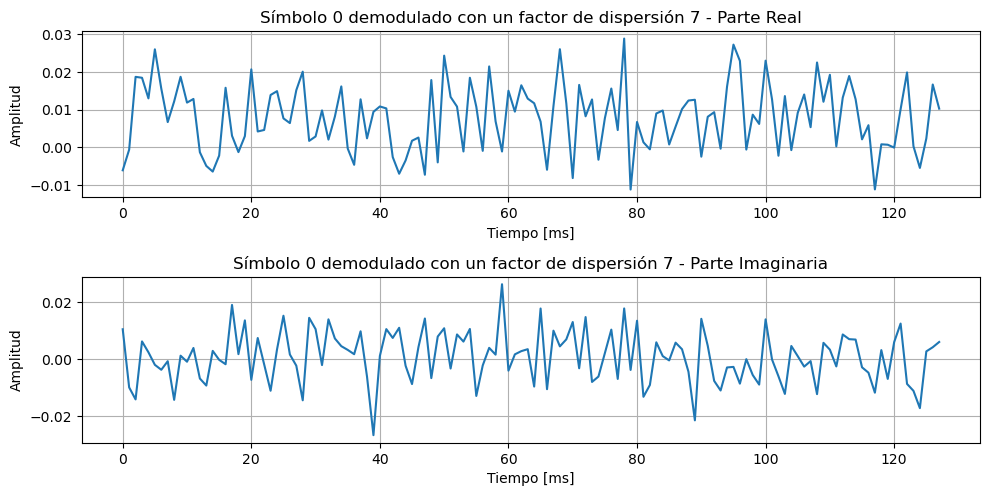

In [130]:
plt.figure(figsize=(10, 12))

# Subplot 1: Símbolos demodulados (parte real)
plot_subplot(dechirped, time_axis, 
             f"Símbolo {s} demodulado con un factor de dispersión {SF}", 
             "Tiempo [ms]", "Amplitud", 1, part='real')

# Subplot 2: Símbolos demodulados (parte imaginaria)
plot_subplot(dechirped, time_axis, 
             f"Símbolo {s} demodulado con un factor de dispersión {SF}", 
             "Tiempo [ms]", "Amplitud", 2, part='imag')

plt.tight_layout()
plt.show()

Al demodular, obtenemos una señal que presenta una frecuencia dominante.

Aplicando la Transformada Rápida de Fourier, podemos identificar los tonos de mayor potencia y, de esta manera, distinguir los símbolos enviados.

In [133]:
dechirped_fft = np.fft.fft(dechirped)

Se grafica la potencia de cada frecuencia, cuyo índice me indica los símbolos recibidos:

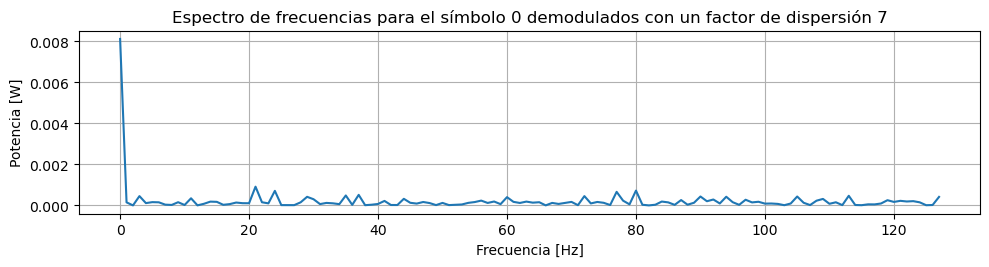

In [136]:
# Gráficas
plt.figure(figsize=(10, 12))

# Subplot 5: Espectro de frecuencias de los símbolos demodulados
plt.subplot(5, 1, 1)

f_sym = (np.arange(num_samples) * Fs / num_samples * 2**SF) / BW
power = np.abs(dechirped_fft)**2 / num_samples
plt.plot(f_sym, power)

plt.title(f"Espectro de frecuencias para el símbolo {str(s)} demodulados con un factor de dispersión {SF}")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [W]")
plt.grid()

plt.tight_layout()
plt.show()

Y, como podemos observar, coincide con el símbolo transmitido.

#### Calculo del error

Para calcular el error, se realiza la modulación y demodulación varias veces. La cantidad de iteraciones está dada por la variable `veces`, que se indicó al principio.

Entonces, se generan y demodulan los símbolos:

In [167]:
def modulacionAndDeteccion(SF, num_samples, base_down_chirp_t, SNR):
    
    aciertos = np.zeros(veces, dtype=int)
    
    for j in range(veces):
        symb_t, symb_f = generar_symb(Ts, num_samples, s, SF)   # 1. Genero la modulación del símbolo
        symb_ruidoso = agregar_ruido(symb_t, SNR, ruido)        # 2. Agrego ruido 
        dechirped = symb_ruidoso * base_down_chirp_t            # 3. Demodulo
        dechirped_fft = np.fft.fft(dechirped)                   # 4. FFT  
        correlation = np.abs(dechirped_fft)**2                  # 5. Correlación
        aciertos[j] = correlation.argmax()                      # 6. Valor máximo en cada iteración

    return sum(aciertos != s)/veces, aciertos

Se calcula la tasa de error:

In [170]:
symbol_error_rate, aciertos = modulacionAndDeteccion(SF, num_samples, base_down_chirp_t, SNR)

print("Tasa de error de símbolo:", symbol_error_rate)

Tasa de error de símbolo: 0.0


Y se elabora el histograma de los símbolos demodulados.

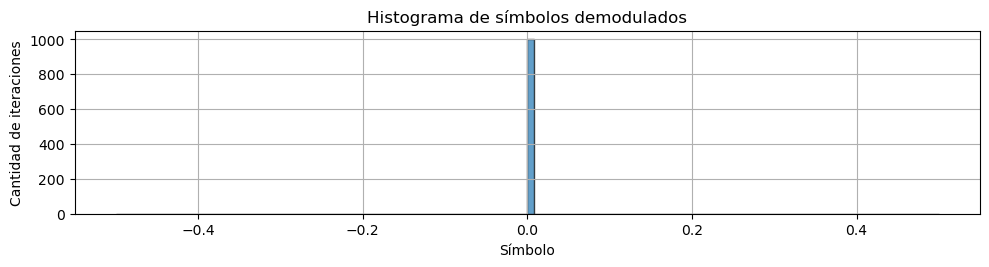

In [173]:
plt.figure(figsize=(10, 12))

plt.subplot(5, 1, 1)

plt.hist(aciertos, bins=2**SF, edgecolor='k', alpha=0.7)
plt.title("Histograma de símbolos demodulados")
plt.xlabel("Símbolo")
plt.ylabel("Cantidad de iteraciones")
plt.grid(True)

plt.tight_layout()
plt.show()

#### Curva de la Tasa de Error de Símbolo (_Symbol Error Rate_ - SER)

Con esta gráfica se analizan los símbolos pérdidos. En el eje vertical me indica la cantidad de pérdidas y en el horizontal la relación entre la energía del símbolo y la densidad espectral de potencia del ruido blanco.

Para ello, se realizan múltiples simulaciones para diferentes valores de SNR y luego se calcula la curva correspondiente a cada uno.

In [185]:
SNR_values = np.arange(-30, 10, 2) # Rango de valores de SNR

Realizamos la simulación:

In [188]:
def calcular_SER(SF, num_samples, base_down_chirp_t):
        
    SER = []

    for SNR in SNR_values:
        symbol_error_rate, _ = modulacionAndDeteccion(SF, num_samples, base_down_chirp_t, SNR)
        SER.append(symbol_error_rate)
    
    return SER

In [190]:
SER = calcular_SER(SF, num_samples, base_down_chirp_t)

Gráficamos la curva de SER:

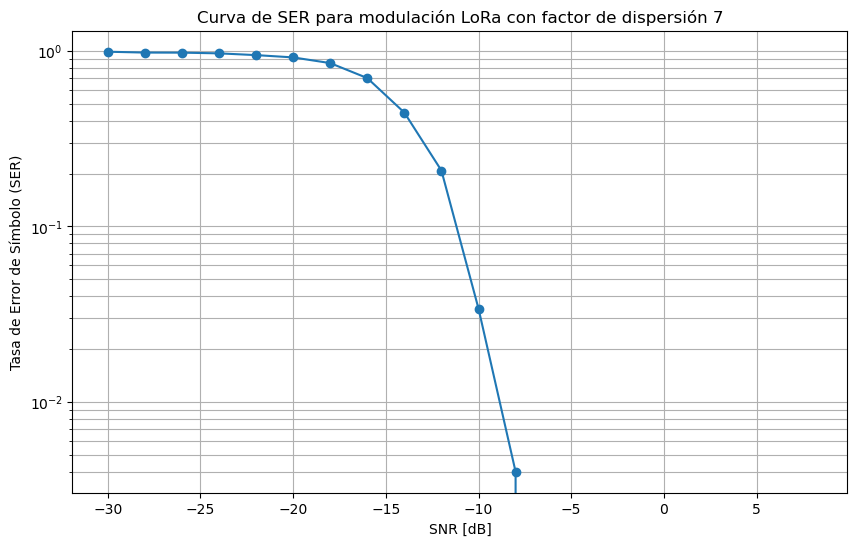

In [192]:
plt.figure(figsize=(10, 6))
plt.semilogy(SNR_values, SER, marker='o', linestyle='-') # Escala logarítmica en el eje y
title_Text1 = f"Curva de SER para modulación LoRa con factor de dispersión {SF}"
plt.title(title_Text1)
plt.xlabel("SNR [dB]")
plt.ylabel("Tasa de Error de Símbolo (SER)")
plt.grid(True, which='both')
plt.show()

#### Curva SER para los distintos SF

Se Realiza lo mismo que antes pero esta vez para cada _Spreading Factor_.

In [197]:
SF_values = [7, 8, 9, 10, 11, 12]  # Spreading Factor [7, 8, 9, 10, 11, 12]

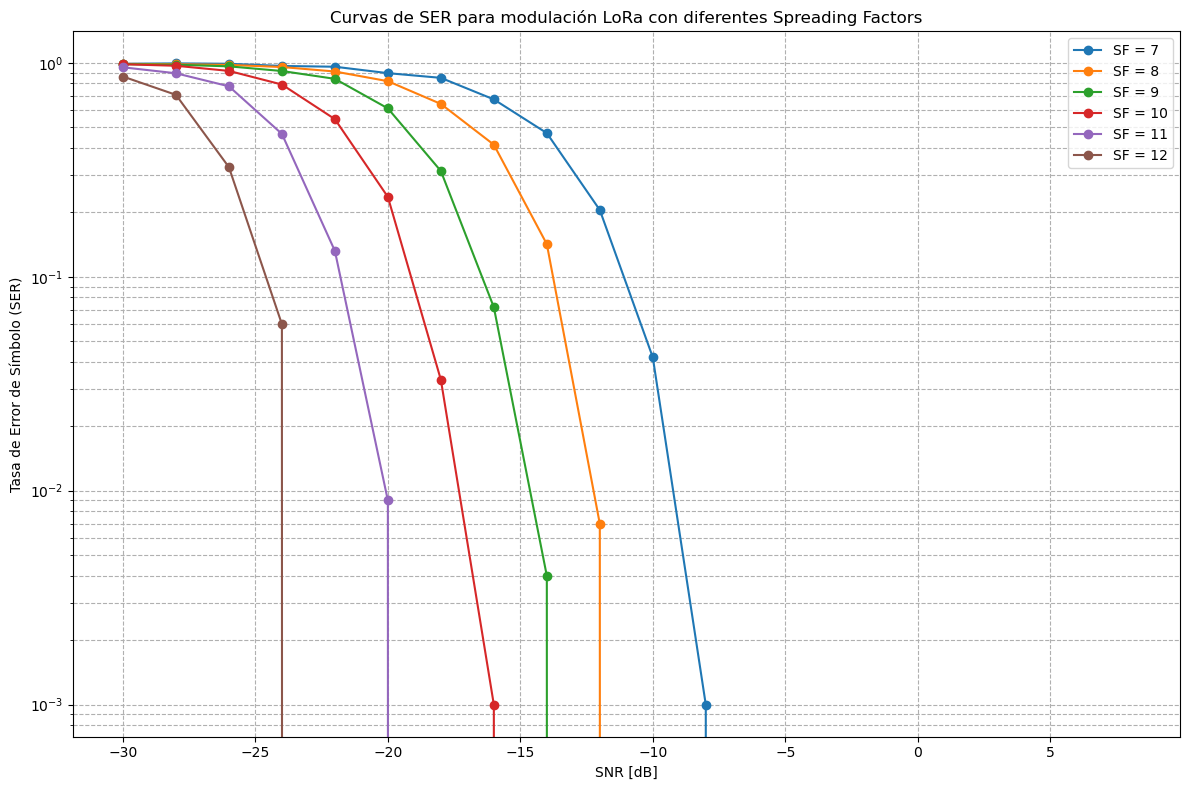

In [199]:
# Graficar curvas de SER para cada SF
plt.figure(figsize=(12, 8))

for SF in SF_values:
    Ts = (2**SF) / BW  # Periodo de cada símbolo
    num_samples = int(Ts * Fs)  # Número de muestras
    
    base_down_chirp_t, _ = calcular_base_down_chirp(SF, num_samples)
    
    ser_values = calcular_SER(SF, num_samples, base_down_chirp_t)
    plt.plot(SNR_values, ser_values, marker='o', label=f'SF = {SF}')

plt.yscale('log')
plt.title('Curvas de SER para modulación LoRa con diferentes Spreading Factors')
plt.xlabel('SNR [dB]')
plt.ylabel('Tasa de Error de Símbolo (SER)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

En ambas curvas de SER, se debe notar que se obtienen resultados por debajo del nivel de ruido, ya que las gráficas se encuentran a la izquierda del cero.

Podemos observar que, cuanto mayor es el SF, más por debajo del nivel de ruido se puede trabajar.

LoRa es capaz de demodular señales que están por debajo del umbral de ruido.

### Simulación de una transmisión y recepción con modulación LoRa de varios símbolos

La idea es la siguiente: 
> La cantidad de bits a transmitir va a depender del _Spreading Factor_, entonces primero se van a definir todos los parámetros que influyen en la simulación y en base a estos se va a generar el mensaje aleatorio a transmitir.
> 
> Este mensaje será modulado mediante LoRa, al cual se le puede agregar ruido gausiano, efectos del canal satelital o que sea un canal ideal.
>
> Cabe aclarar que no se van a generar los símbolos del preámbulo y de la sincronización, solo se va a modular y demodular la información. Los datos van a ser una serie de símbolos aleatorios, comprendidos entre $0$ y $2^{SF}$ de manera aleatoria.  
> 
> Luego se simula la recepción y se procede a analizar el error.

Se comienza definiendo los parámetros de la simulación:

* `SF` Puede tomar valores entre $7$ y $12$.

* `BW` es el ancho de banda en $Hz$. Me indica la diferencia entre la frecuencia inicial y final de los "chirridos".
  
* `SNR` es una medida que se utiliza para comparar el nivel de una señal deseada con el nivel de ruido de fondo. Se coloca en $dB$.
  
  Si es _positivo_ significa que la potencia de la señal es mayor que la potencia del ruido.

  Si es _negativo_ significa que la potencia del ruido es mayor que la potencia de la señal.
  
* `cant_bits` es la cantidad de símbolos a representar va a depender de `SF`.
  $$2^7 = 128$$
  $$2^8 = 256$$
  $$2^9 = 512$$
  $$2^{10} = 1024$$
  $$2^{11} = 2048$$
  $$2^{12} = 4096$$
* `Fs` es la frecuencia de muestreo, se utiliza para calcular el número de muestras en cada símbolo. 
* La variable `ruido` es para indicar el tipo del mismo. (0: sin ruido, 1: AWGN, 2: efectos del canal satelital) 

In [ ]:
SF  = 7                  # Spreading Factor [7,8,9,10,11,12]
BW  = 1000               # Ancho de banda
SNR = 0                  # Signal Noise Radio
cant_bits = 10000        # Cantidad de símbolos a transmitir  
Fs  = 1000               # Frecuencia de muestreo 
ruido = 1                # Tipo de ruido: 0-> Sin ruido, 1 -> AWGN, 2 -> Canal Satelital                               

#### Transmisor

Teniendo en cuenta el factor de dispersión (`SF`), generamos el mensaje aleatorio a enviar. Serán símbolos aleatorios entre $0$ a $2^{SF} -1$.

In [ ]:
x = np.random.randint(0, 2**SF, size=cant_bits)

El vector $x$ representa directamente la salida del encoder.

##### Modulación

Se procede a definir el periodo de cada símbolo y su tasa de muestreo para hacer uso de la función `generar_symb` definida anteriormente.

In [ ]:
Ts = (2**SF)/BW            # Periodo de cada símbolo
num_samples = int(Ts * Fs) # Número de muestras

print("Duración de casa símbolo: ", Ts, " [S]")

Se definen las listas para guardar los resultado devueltos por la función. 
Y se recorre el vector que contiene la información ($x$), para modular cada símbolo:

In [ ]:
all_symb_t = []
all_symb_f = []

# Recorrer el vector x y llamar a generar_symb para cada valor
for s in x:
    symb_t, symb_f = generar_symb(Ts, num_samples, s, SF)
    all_symb_t.append(symb_t)
    all_symb_f.append(symb_f)

Procedemos a gráficar como se verían las variaciones de frecuencia y de tiempo por símbolo en el eje real.

Se puede mencionar que cambiando la variable `num_symbols_to_plot` se modifica la cantidad de símbolos a ver. Recordar que la cantidad total de símbolos se definió al principio con la variable `cant_bits` a transmitir.

In [ ]:
# Número de símbolos a graficar y parte del mensaje a mostrar
num_symbols_to_plot = 3
message_part = 2**SF   # Cantidad de puntos de cada símbolo

# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 1: Variación de frecuencia por símbolo (solo los primeros símbolos)
plt.subplot(5, 1, 1)

for i in range(num_symbols_to_plot):
    time_offset = i * num_samples * 1000 / Fs
    plt.plot(time_offset + np.arange(message_part) * 1000 / Fs, all_symb_f[i][:message_part].real, label=f'Símbolo {x[i]}')

title_Text1 = f"Variación de frecuencia por símbolo con un factor de dispersión {SF} - Parte Real"
plt.title(title_Text1)
plt.xlabel("Tiempo [ms]")
plt.ylabel("Frecuencia [Hz]")
plt.legend()
plt.grid()

# Subplot 2: Variación de tiempo por símbolo (solo los primeros símbolos)
plt.subplot(5, 1, 2)

for i in range(num_symbols_to_plot):
    time_offset = i * num_samples * 1000 / Fs
    plt.plot(time_offset + np.arange(message_part) * 1000 / Fs, all_symb_t[i][:message_part].real, label=f'Símbolo {x[i]}')

title_Text2 = f"Variación de tiempo por símbolo con un factor de dispersión {SF} - Parte Real"
plt.title(title_Text2)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()

Con las imagenes anteriores podemos ver como es la modulación LoRa.

#### Ruido

En este momento se le puede agregar ruido a la señal, depende de como se configuro el parámetro antes. Para ello se utilizará la función `agregar_ruido` que se explicó antes.

Se generan los símbolos ruidosos.

In [ ]:
symb_ruidosos = []

for symb in all_symb_t:
    symb_ruidoso = agregar_ruido(symb, SNR, ruido)
    symb_ruidosos.append(symb_ruidoso)

Y podemos nuevamente gráficar los primeros símbolos para apreciar el efecto.

In [ ]:
# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 2: Variación de tiempo por símbolo (solo los primeros símbolos)
plt.subplot(5, 1, 3)

for i in range(num_symbols_to_plot):
    time_offset = i * num_samples * 1000 / Fs
    plt.plot(time_offset + np.arange(message_part) * 1000 / Fs, symb_ruidosos[i][:message_part].real, label=f'Símbolo {x[i]}')

title_Text2 = f"Variación de tiempo por símbolo con un factor de dispersión {SF} - Parte Real"
plt.title(title_Text2)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()

#### Receptor

Para recibir la señal lo primero que se hace es detectar la parte del préambulo y de sincronización. Estas se eliminan, y nos quedamos con la información.

##### Demodulación

Para generar la demodulación, se debe generar un "chirp" o "chirrido" como antes vimos. De cierta manera es análogo a una señal portadora o _carrier_ en otras modulaciones como AM, FM, etc. 

In [ ]:
base_down_chirp = np.zeros(num_samples, dtype=np.complex128)
k = 0

for n in range(num_samples):
    if k >= 2**SF:
        k = k - 2**SF
    k = k + 1
    base_down_chirp[n] = (1 / np.sqrt(2**SF)) * np.exp(-1j * 2 * np.pi * k * (k / (2**SF * 2))) # Chirps descendentes

Y se puede gráficar para observar como sería la señal utilizada para la demodulación.

In [ ]:
time_axis = np.arange(num_samples) * 1000 / Fs     #Vector tiempo que será usado en esta imagne y la siguiente

# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 3: Chirp utilizado para demodular
plt.subplot(5, 1, 4)
plt.plot(time_axis[:message_part], base_down_chirp[:message_part].real)
title_Text3 = f"Chirp utilizado para demodular con factor de dispersión {SF} - Parte Real"
plt.title(title_Text3)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.subplot(5, 1, 5)
plt.plot(time_axis[:message_part], base_down_chirp[:message_part].imag)
title_Text3 = f"Chirp utilizado para demodular con factor de dispersión {SF} - Parte Imaginaria"
plt.title(title_Text3)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

Notar que `time_axis` es un arreglo que contiene los tiempo correspondientes a cada "chirrido".
Se seleccionó la primer muestra del arreglo de tiempo con `message_part`, que me indica la cantidad de puntos de cada símbolo. De esta manera se definió el vector tiempo.

Y el vector `base_down_chirp` es el que contiene los valores del chirrido descendentes a lo largo del tiempo, como se indico un poco más arriba.

Ahora se realiza propiamente la demodulación, para ello se itera sobre cada símbolo y aplicó la demodulación a cada uno. Tener en cuenta que `symb_ruidosos` contiene los símbolos modulados con el ruido agregado.

In [ ]:
all_dechirped = []

for i in symb_ruidosos:
    dechirped = i * base_down_chirp
    all_dechirped.append(dechirped)

Procedemos a graficar los símbolos demodulados.

In [ ]:
# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 4: Símbolos demodulados
plt.subplot(5, 1, 1)

for i in range(num_symbols_to_plot):
    plt.plot(time_axis, all_dechirped[i][:message_part].real, label=f'Símbolo {x[i]}')
    
plt.title(f"Símbolos demodulados con un factor de dispersión {SF} - Parte Real")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")
plt.legend()

# Subplot 4: Símbolos demodulados
plt.subplot(5, 1, 2)

for i in range(num_symbols_to_plot):
    plt.plot(time_axis, all_dechirped[i][:message_part].imag, label=f'Símbolo {x[i]}')
    
plt.title(f"Símbolos demodulados con un factor de dispersión {SF} - Parte Imaginaria")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()

Como podemos ver al demodular nos quedamos con varios tonos, es decir, distintas señales de que tienen una frecuencia dominante.

Es necesario recordar que vamos a tener tantos tonos como símbolos diferentes tenga la señal.

Aplicando la Transformada Rápida de Fourier podemos saber cuales son los tonos de mayor potencia y de esta manera distinguir los símbolos enviados.

In [ ]:
all_dechirped_fft = []

for i in all_dechirped:
    dechirped_fft = np.fft.fft(i)
    all_dechirped_fft.append(dechirped_fft)

Nuevamente gráficamos, esta vez, la amplitud de cada frecuencia para poder verificar a simple vista los primeros símbolos recibidos.

In [ ]:
# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 5: Espectro de frecuencias de los símbolos demodulados
plt.subplot(5, 1, 1)

for i in range(num_symbols_to_plot):
    f_sym = (np.arange(num_samples) * Fs / num_samples * 2**SF) / BW
    power = np.abs(all_dechirped_fft[i])**2 / num_samples
    plt.plot(f_sym, power, label=f'Símbolo {x[i]}')

plt.title(f"Espectro de frecuencias para los símbolos demodulados con un factor de dispersión {SF}")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [W]")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Se puede ver que las frecuencias de mayor potencia representan a los símbolos obtenidos, que son iguales a los símbolos enviados.

Cambiando los parámetros del inicio de la simulación, obtenenmos diferentes casos, y poder ver como influye el ruido para distintos niveles de _Spreading Factor_. 

### Envío y Recepción por SDR

Una radio definida por software (SDR) es un sistema de comunicaciones de radiofrecuencia que cuenta con etapas de transmisión y recepción reconfigurables. Esta característica permite adaptar al SDR a distintos sistemas y protocolos de comunicaciones utilizando los mismos recursos de hardware. 

A continuación se presenta el diagra en bloques de la etapa transmisora y receptora del SDR.

In [ ]:
Image(filename='Imagenes/sdr_block_diagram.png')

Para configurar los parámetros que controlan al [AD9363](https://www.analog.com/en/products/ad9363.html#product-overview), un transceptor del tipo conversión directa, se  hace uso de la interfaz [pyadi-iio](https://pypi.org/project/pyadi-iio/), un módulo diseñado en lenguaje Python, que permite interactuar con los dispositivos diseñados por Analog Device con un alto grado de abstracción. Para su instalación se debe ejecutar.

In [ ]:
#! pip install pyadi-iio

mientras que para su uso hay que importar la siguiente biblioteca:

In [ ]:
import adi

Otras instalaciones que pueden servir son las siguientes:

In [ ]:
#! pip install matplotlib
#! pip install scikit-dsp-comm
#! pip install scikit-commpy

En las siguientes lineas de código se crea el objeto "sdr" y se lo vincula con el dispositivo que se encuentra en la dirección proporcionada por la variable "Uri".

In [ ]:
Uri = "ip:192.168.1.35" # "ip:192.168.1.35" "ip:192.168.1.34" "ip:192.168.1.33" "ip:192.168.1.32"
sdr = adi.Pluto(Uri)

Definimos los parametros de la modulación LoRa:

In [ ]:
SF  = 7                  # Spreading Factor [7,8,9,10,11,12]
BW  = 1000               # Ancho de banda
cant_bits = 10000        # Cantidad de símbolos a transmitir  
#Fs  = 1000               # Frecuencia de muestreo 

Generamos la señal a transmitir:

In [ ]:
nSamples     = 2**20                                   #Número de muestras
samplingRate = 2.0e6                                   #Promedio de muestas
frec         = samplingRate/8                          #Frecuencia 
txSignalExp  = complexExp(nSamples,frec,samplingRate)  #Señal recibida

#### Transmisión

Se transmite:

In [ ]:
#------------------------------- Transmitter ------------------------------- 
sdr.tx(txSignal*(2**15-1))

#### Recepción

Para evitar capturar la señal en algún estado transitorio inicial y para eliminar del buffer del receptor muestras de señales tomadas con anterioridad, ejecuta lo siguiente antes de recibir la señal:

In [ ]:
#Clear RX Buffer
for i in range(10):
    raw_data = sdr.rx()
    
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()

Normailizamos la señal recibida para que tenga potencia unitaria.

In [ ]:
desviacionReal = rxSignal.real.std()
print("Desviacion Real: ", desviacionReal)

desviacionImag = rxSignal.imag.std()
print("Desviacion Imaginaria: ",desviacionImag)

rxSignalRealN = rxSignal.real/desviacionReal
rxSignalImagN = rxSignal.imag/desviacionImag

#### Grafica temporal de la señal recibida

#### Grafica en frecuencia de la señal recibida

#### Conclusiones

#### Transmisión con máxima atenuación

Dado que no es posible apagar la etapa transmisora del SDR, es recomendable antes de finalizar la experiencia, dejar configurado el transmisor con la máxima atenuación posible, asegurarse que las frecuencias de transmisión y recepción no coinciden y cargar al Buffer transmisor con ceros. Esto permitirá minimizar cualquier posible interferencia por parte del SDR.

In [ ]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0 = -89 
sdr.tx_lo                 = int(2400e6)
sdr.rx_lo                 = int(950e6)
sdr.tx(np.zeros(2048))

# Destroy radio object
del(sdr)

## Bibliografía

### Vídeos

* https://www.youtube.com/watch?v=8AWY80NKc-A
* https://www.youtube.com/watch?v=kNXnCjJplZw&t
* https://www.youtube.com/watch?v=mKmOlMqrbKk
* https://www.youtube.com/watch?v=dxYY097QNs0
* https://www.youtube.com/watch?v=0zNFtDZ7bMs
* https://www.youtube.com/watch?v=dpA-uWL6FUA
* https://www.youtube.com/watch?v=jHWepP1ZWTk
* https://www.youtube.com/watch?v=VipcNAGt89A
* https://www.youtube.com/watch?v=qs7Lz9g-mgg
* https://www.youtube.com/watch?v=YQ7aLHCTeeE

### Papers

* [L. Vangelista, "Frequency Shift Chirp Modulation: The LoRa Modulation", in IEEE Signal Processing Letters, vol. 24, no. 12, pp. 1818-1821, Dec. 2017, doi: 10.1109/LSP.2017.2762960](https://ieeexplore.ieee.org/document/8067462) 
* [Ullah, Pasolini, Mikhaylov, Alves, "Understanding the Limits of Lora Direct-to-Satellite: The Doppler Perspectives", in IEEE Open Journal of the Communications Society, vol. 5](https://ieeexplore.ieee.org/document/10335927/references#references)
* [Mekki, Bajic, Chaxel, Meyer, "Overview of Cellular LPWAN Technologies for IoT Deployment: Sigfox, LoRaWAN, and NB-IoT", in 2018 IEEE International Conference on Pervasive Computing and Communications Workshops](https://ieeexplore.ieee.org/document/8480255)

### Páginas web

* https://www.sghoslya.com/p/lora_9.html
* http://www.sghoslya.com/
* https://revspace.nl/DecodingLora
* https://dl.acm.org/doi/10.1145/3546869#d1c2855
* https://cris.vtt.fi/en/publications/understanding-the-limits-of-lora-direct-to-satellite-the-doppler-
* https://en.wikipedia.org/wiki/Chirp
* https://wiki.dfrobot.com/What_is_LoRa
* https://www.digikey.es/es/articles/how-to-quickly-start-low-power-wireless-iot-sensing

### Repositorios

* https://github.com/rpp0/gr-lora

### Libros

* _Principles of Digital Communication_ de Bixio Rimoldi